### **Segmentación de clientes con mayor propensión para diciembre de 2024**


Para este presente estudio se tomaron en cuenta las siguientes consideraciones.

1. La base de cleintes a utilizar comprende clientes que hayan tenido al menos una compra en los doce ultimos meses. Esto comprende desde 26-11-2023 hasta el 26-11-2024. Ademas se añade el filtro de marca 'Colloky', y filtros de tipo de cliente que no sea 'Venta no fidelizada' y 'no válido'. Esto nos da un total de **876.163** rut únicos.
2. Luego, nos traemos el historial de transacciones de 24 meses de estos rut únicos. (26-11-2022 al 26-11-2024), con motivo de poder entrenar de mejor manera el modelo de machine learning.

#### **Código extracción de datos**

In [1]:
import pandas as pd

# Definir las rutas de los archivos CSV
archivos_csv = [
    r"C:\Users\constanza.perez\Downloads\bq-results-20241128-014512-1732758333933.csv",
    r"C:\Users\constanza.perez\Downloads\bq-results-20241128-014226-1732758165767.csv",
    r"C:\Users\constanza.perez\Downloads\bq-results-20241128-013809-1732757943209.csv",
    r"C:\Users\constanza.perez\Downloads\bq-results-20241128-012901-1732757390576.csv",
    r"C:\Users\constanza.perez\Downloads\bq-results-20241128-012207-1732756955491.csv"
]

# Leer cada archivo CSV y almacenar en una lista
dfs = []
for archivo in archivos_csv:
    df_temp = pd.read_csv(archivo, low_memory=False)  # Cargar el CSV con low_memory=False
    dfs.append(df_temp)
    
    # Imprimir el conteo de filas de cada archivo CSV
    print(f'Archivo: {archivo} - Cantidad de filas: {df_temp.shape[0]}')

# Unir todos los DataFrames en uno solo
df_unificado = pd.concat(dfs, ignore_index=True)

# Imprimir la cantidad total de filas y columnas del DataFrame unificado
print(f'\nCantidad total de filas en el DataFrame unificado: {df_unificado.shape[0]} - Cantidad total de columnas: {df_unificado.shape[1]}')


Archivo: C:\Users\constanza.perez\Downloads\bq-results-20241128-014512-1732758333933.csv - Cantidad de filas: 261956
Archivo: C:\Users\constanza.perez\Downloads\bq-results-20241128-014226-1732758165767.csv - Cantidad de filas: 1009824
Archivo: C:\Users\constanza.perez\Downloads\bq-results-20241128-013809-1732757943209.csv - Cantidad de filas: 1633467
Archivo: C:\Users\constanza.perez\Downloads\bq-results-20241128-012901-1732757390576.csv - Cantidad de filas: 1435512
Archivo: C:\Users\constanza.perez\Downloads\bq-results-20241128-012207-1732756955491.csv - Cantidad de filas: 1992757

Cantidad total de filas en el DataFrame unificado: 6333516 - Cantidad total de columnas: 29


#### **Limpieza de correos**

Posteriormente, procedemos a seleccionar únicamente los clientes únicos con correo válido. Por ello, se realizan los siguientes consideraciones a los correos.

1. Correos que tengan una cantidad igual o menor a 105 boletas únicas en los 24 meses estudiados.
2. Correos que tengan una cantidad igual o menor a 5 boletas únicas en un día.
3. Correos que tengan el carácter '@' dentro de su extensión.
4. Correos que tengan el carácter '.' dentro de su extensión.
5. Correos que no contengan las palabras de la empresa, tales como, 'colgram' , 'colloky', 'opaline'.
6. Correos que tengan al menos dos letras, carácteres o números después del '@' y antes del '.'
7. Correos con extensión mayor o igual a 7.
8. Correos con carácteres especiales no permitidos, con dominios inválidos.
9. Correos que terminen con dominios válidos. (tales como, '.cl'.'.com','.es')
10. Borramos los espacios, al principio, entremedio y al final de cada correo.
11. Correos que se clasifico como 'mala práctica' de determinadas tiendas (sección posterior se explica).

Posterior a ello, se toma la determinación de mantener solo las transacciones que no tengan valores vacíos o nulos en las columnas estudiadas.

Finalmente, nos quedamos con un total de **603.810** clientes únicos (correos únicos).

#### **Código de limpieza de correos**

In [2]:
import pandas as pd
import numpy as np
# Filtrar los registros donde 'correo' no sea nulo, no sea cero, eliminar espacios,
# termine con dominios específicos y no contenga las palabras no deseadas
df_final = df_unificado[
    df_unificado['correo'].notna() &  # Correo no nulo
    (df_unificado['correo'] != 0) &  # Correo no sea igual a 0
    df_unificado['correo'].str.replace(' ', '').str.contains(r'@', na=False) &  # Correo contiene '@' y no tiene espacios
    df_unificado['correo'].str.replace(' ', '').str.contains(r'\.', na=False) &  # Correo tiene al menos un punto
    df_unificado['correo'].str.replace(' ', '').str.endswith(('.cl', '.com', '.es', '.net', '.org', '.edu')) &  # Correo termina con uno de los dominios especificados
    ~df_unificado['correo'].str.contains('colgram|colloky|opaline|coloky|notiene', case=False, na=False)  # Correo no contiene estas palabras
]

# Agregar la condición de que haya al menos 2 letras, caracteres o números después del '@' y antes del '.'
df_final = df_final[df_final['correo'].str.replace(' ', '').str.contains(r'@[a-zA-Z0-9]{2,}\.', na=False)]

# Agregar la condición de que el largo del correo sea mayor o igual a 7
df_final = df_final[df_final['correo'].apply(lambda x: len(x.replace(' ', '')) >= 7)]

# Filtrar los correos específicos que deben eliminarse por tener más de 250 boletas en 24 meses
correos_a_eliminar = [
    'x@gmail.com', '.@.', 'cliente@gmail.com', '.', 'sincorreo@gmail.com',
    'gmail@com', 'daniela.umana@rappi.com', 'd@d'
]

df_final = df_final[~df_final['correo'].isin(correos_a_eliminar)]  # Eliminar los correos no deseados

# Eliminar las filas que contienen valores nulos en las columnas específicas
df_final = df_final.dropna(subset=['fecha', 'boleta', 'cod_tienda', 'montoneto', 'marca', 'cantidad', 'area', 
                                   'temporada', 'correo', 'genero', 'canal', 'edad', 'porcentaje_descuento',
                                   'edad_meses_talla_hoy', 'edad_ano_talla_hoy'])

# Filtrar correos temporales o desechables
dominios_temporales = ['10minutemail.com', 'temp-mail.org', 'mailinator.com']
df_final = df_final[~df_final['correo'].str.endswith(tuple(dominios_temporales))]

# Validación del formato del correo
regex_email = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
df_final = df_final[df_final['correo'].str.match(regex_email)]

# Correos con subdominios inválidos
df_final = df_final[~df_final['correo'].str.contains(r'@[^@]+\.[^@\.]+\.[^@\.]+')]

# Verificar caracteres especiales no permitidos
df_final = df_final[df_final['correo'].str.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$')]


# Convertir la columna 'fecha' al formato de fecha
df_final['fecha'] = pd.to_datetime(df_final['fecha'])

# Agrupar por fecha y correo, y contar el número de boletos por correo en cada fecha
conteo_correos_fecha = df_final.groupby(['fecha', 'correo']).size().reset_index(name='conteo')

# Filtrar los correos que tienen más de 5 boletos en una fecha específica (se consideran inválidos)
correos_invalidos_fecha = conteo_correos_fecha[conteo_correos_fecha['conteo'] > 5]['correo'].unique()

# Contar los boletos únicos por correo en df_final
conteo_boletas_unicas = df_final.groupby('correo')['boleta'].nunique().reset_index(name='conteo_boletas_unicas')

# Filtrar los correos que tienen más de 105 boletos únicos
correos_invalidos_boletas = conteo_boletas_unicas[conteo_boletas_unicas['conteo_boletas_unicas'] > 105]['correo'].unique()

# Combinar ambas listas de correos inválidos (correos que violan alguna de las dos condiciones)
correos_invalidos = np.concatenate([correos_invalidos_fecha, correos_invalidos_boletas])

# Filtrar el dataframe original para obtener solo los registros de correos válidos (eliminar los inválidos)
df_final_filtrado = df_final[~df_final['correo'].isin(correos_invalidos)]

# Si deseas agregar los correos con más de 5 boletos o más de 105 boletos únicos a una lista de correos a eliminar
correos_a_eliminar = list(correos_invalidos)

# Usar extend para añadir los correos inválidos a la lista 'correos_a_eliminar' si no está vacía
correos_a_eliminar.extend(correos_invalidos.tolist())



# Eliminar los correos no deseados
df_final = df_final[~df_final['correo'].isin(correos_a_eliminar)]

# Definir las columnas a conservar
columnas_a_conservar = ['fecha', 'boleta', 'montoneto', 'marca','sku',
                        'cantidad', 'area', 'temporada', 'correo', 'genero', 'canal', 
                        'edad', 'preciolleno', 'edad_meses_talla_hoy', 'edad_ano_talla_hoy']

# Crear el nuevo DataFrame df_final con las columnas seleccionadas
df_final = df_final[columnas_a_conservar]

# Verificar el tamaño del DataFrame final después de aplicar los filtros
print(f'Nuevo tamaño del DataFrame df_final con "correo" filtrado: {df_final.shape[0]}')

# Contar los correos únicos
correos_unicos = df_final['correo'].nunique()

# Imprimir el conteo de correos únicos
print(f'Número de correos únicos en el DataFrame filtrado: {correos_unicos}')


Nuevo tamaño del DataFrame df_final con "correo" filtrado: 2503870
Número de correos únicos en el DataFrame filtrado: 603810


#### **Hallazgos de malas prácticas de vendedores**

Se visualiza que algunas tiendas tienden a utilizar un correo único más de 10 veces al día (boletas únicas al día).
Se entregan print para visualizar la situación.
Finalmente, se toma la decisión de eliminar aquellos correos que tienen un conteo mayor a 20 SKU distintivos al día.

In [5]:
import pandas as pd
import os

# Convertir la columna 'fecha' al formato de fecha
df_unificado['fecha'] = pd.to_datetime(df_unificado['fecha'])

# Agrupar y contar el uso de cada correo por día y tienda
conteo_correos_tienda = df_unificado.groupby(['fecha', 'correo', 'cod_tienda']).size().reset_index(name='conteo')

# Obtener el día con el máximo conteo para cada correo
max_conteo_por_correo = conteo_correos_tienda.loc[conteo_correos_tienda.groupby('correo')['conteo'].idxmax()]

# Filtrar correos con conteo mayor a 20
correos_filtrados = max_conteo_por_correo[max_conteo_por_correo['conteo'] > 20]

# Exportar los datos filtrados a un archivo CSV
ruta = r'C:\Users\constanza.perez\OneDrive - Colgram\Escritorio'
correos_filtrados.to_csv(os.path.join(ruta, 'correos_repetidos_resumen.csv'), index=False)

print("Los datos filtrados han sido exportados exitosamente a 'C:\\Users\\constanza.perez\\OneDrive - Colgram\\Escritorio\\correos_repetidos_resumen.csv'.")


Los datos filtrados han sido exportados exitosamente a 'C:\Users\constanza.perez\OneDrive - Colgram\Escritorio\correos_repetidos_resumen.csv'.


In [4]:
import pandas as pd

# Asegúrate de que la columna 'fecha' esté en formato de fecha
df_unificado['fecha'] = pd.to_datetime(df_unificado['fecha'])

# Filtrar las transacciones para el correo, fecha y tienda especificados
correo_especifico = 'facturasdulcehogar@gmail.com'
fecha_especifica = '2023-10-02'
cod_tienda_especifica = 115

# Filtrar las filas que coincidan con los criterios especificados
filtro = (df_unificado['correo'] == correo_especifico) & \
         (df_unificado['fecha'] == fecha_especifica) & \
         (df_unificado['cod_tienda'] == cod_tienda_especifica)

# Contar las transacciones que cumplen con los criterios
conteo = df_unificado[filtro].shape[0]

print(f"El correo {correo_especifico} se utilizó {conteo} veces el {fecha_especifica} en la tienda {cod_tienda_especifica}.")


El correo facturasdulcehogar@gmail.com se utilizó 357 veces el 2023-10-02 en la tienda 115.


In [5]:
import pandas as pd

# Asegúrate de que la columna 'fecha' esté en formato de fecha
df_unificado['fecha'] = pd.to_datetime(df_unificado['fecha'])

# Filtrar las transacciones para el correo y fecha especificados
correo_especifico = 'facturasdulcehogar@gmail.com'
fecha_especifica = '2023-10-02'

# Filtrar las filas que coincidan con los criterios especificados
filtro = (df_unificado['correo'] == correo_especifico) & \
         (df_unificado['fecha'] == fecha_especifica)

# Obtener las boletas únicas
boletas_unicas = df_unificado[filtro]['boleta'].nunique()

print(f"El correo {correo_especifico} tiene {boletas_unicas} boletas únicas en la fecha {fecha_especifica}.")


El correo facturasdulcehogar@gmail.com tiene 13 boletas únicas en la fecha 2023-10-02.


### **Filtros y cálculo de variables previos a la implementación del modelo**

Procedemos a dejar la columna fecha en un formato compatible para su uso.

Luego, aplicamos los siguientes filtros.

1. Columna 'monto neto' será difrente a cero y mayor a 900.
2. Columna 'edad_ano_talla_hoy' debe ser menor a 12 años.
3. Columna 'edad_meses_talla_hoy' debe ser menor a 144 meses.
4. Columna 'edad' del cliente está sin filtro de edad.
5. Calcumos el 'ticket promedio' agrupado por boleta. Posteriormente, dado que cada cliente tiene múltiples boletas, y por ende, múltiples ticket promedio, para obtener el ticket promedio por cliente (correo único), la calculamos como el promedio de los ticket promedio de las boletas que tuvo ese cliente.
6. Calculamos la 'frecuencia' de cada correo, como la cantidad de boletas únicas que tuvo.
7. Calculamos el 'tiempo promedio entre compra (TPC)' de cada correo, como la cantidad de días en promedio que un cliente efectuaba una siguiente compra.
8. Consideramos ticket promedio por correo debe ser menor o igual a 200.000 CLP.
9. Para cuando la frecuencia de un correo sea igual a uno, el ticket promedio debe ser menor o igual a 200.000 CLP.
10. Calculamos el descuento agrupado por correo único, como 1 - (Sumatoria Monto Neto *1,19/ Sumatoria Precio Lleno)

#### **Código implementación de variables y reglas de negocio**

In [3]:
import pandas as pd
import numpy as np

# Cargar el archivo Excel
ruta_excel = "C:/Users/constanza.perez/Downloads/Lista_Precio_Colloky (1).xlsx"
df_precios = pd.read_excel(ruta_excel, sheet_name='Lista_Precio_Colloky')

# Asegurarse de que la columna 'fecha' está en el formato de fecha
df_final['fecha'] = pd.to_datetime(df_final['fecha'])

# Excluir los registros con monto neto igual a cero, los registros donde monto neto sea menor o igual a 900,
# los registros con 'edad_ano_talla_hoy' >= 10,
# los registros con 'edad_meses_talla_hoy' >= 120, y la edad debe ser mayor o igual a 18.
df_final_1 = df_final[
    (df_final['montoneto'] != 0) &  # Excluir monto neto igual a cero
    (df_final['montoneto'] > 900) &  # Condición de monto neto mayor a 900
    (df_final['edad_ano_talla_hoy'] < 12) &  # Condición de edad_ano_talla_hoy menor a 10
    (df_final['edad_meses_talla_hoy'] < 144)  # Condición de edad_meses_talla_hoy menor a 120 (10 años en meses)
].copy()  # Crear una copia del DataFrame original

# Verificar el tamaño del DataFrame final
print(f'Nuevo tamaño del DataFrame final sin registros con monto neto igual a cero, monto neto <= 900, edad_ano_talla_hoy >= 10, edad_meses_talla_hoy >= 120 y edad >= 18: {df_final_1.shape[0]}')

# Crear y calcular 'monto neto final' multiplicado por 1,19
df_final_1['monto neto final'] = df_final_1['montoneto'] * df_final_1['cantidad'] * 1.19

# Calcular 'monto neto final' total por boleta
df_grouped = df_final_1.groupby('boleta').agg({'monto neto final': 'sum'}).reset_index()

# Calcular ticket promedio inicial
df_grouped['TICKET PROMEDIO INICIO'] = df_grouped['monto neto final']


# Unir con el DataFrame original
df_final_1 = df_final_1.merge(df_grouped[['boleta', 'TICKET PROMEDIO INICIO']], on='boleta', how='left')

# Calcular el ticket promedio final por correo
df_ticket_promedio_correo = df_final_1.groupby('correo').agg({'TICKET PROMEDIO INICIO': 'mean'}).reset_index()
df_ticket_promedio_correo.rename(columns={'TICKET PROMEDIO INICIO': 'TICKET PROMEDIO'}, inplace=True)

# Unir el ticket promedio final al DataFrame original (opcional)
df_final_1 = df_final_1.merge(df_ticket_promedio_correo[['correo', 'TICKET PROMEDIO']], on='correo', how='left')

# Calcular la frecuencia de compras por cada 'correo'
df_frecuencia = df_final_1.groupby('correo')['boleta'].nunique().reset_index()
df_frecuencia.columns = ['correo', 'frecuencia']

# Merge con el DataFrame original
df_final_1 = df_final_1.merge(df_frecuencia, on='correo', how='left')

# Calcular el tiempo entre compras para cada 'correo'
df_final_1 = df_final_1.sort_values(by=['correo', 'fecha'])
df_final_1['days_since_last_purchase'] = df_final_1.groupby('correo')['fecha'].diff().dt.days

# Calcular TPC como el promedio de días entre compras, excluyendo la primera compra (NaN values) y el día de la compra
df_tpc = df_final_1[df_final_1['days_since_last_purchase'] > 1].groupby('correo')['days_since_last_purchase'].mean().reset_index()
df_tpc.columns = ['correo', 'TPC']

# Merge con el DataFrame original
df_final_1 = df_final_1.merge(df_tpc, on='correo', how='left')

# Eliminar la columna 'days_since_last_purchase' ya que no es necesaria en el resultado final
df_final_1 = df_final_1.drop(columns=['days_since_last_purchase'])

# Eliminar los valores atípicos de 'TICKET PROMEDIO'
df_final_1 = df_final_1[df_final_1['TICKET PROMEDIO'] <= 200000]

# Nueva condición: si la frecuencia es igual a 1, el ticket promedio no puede ser mayor a 500,000
df_final_1 = df_final_1.drop(df_final_1[(df_final_1['frecuencia'] == 1) & (df_final_1['TICKET PROMEDIO'] >= 200000)].index)

# Imprimir el conteo de correos únicos
conteo_correos_unicos = df_final_1['correo'].nunique()
print(f'Conteo de correos únicos: {conteo_correos_unicos}')

# Agregar la columna 'Precio Un.' al DataFrame df_final_1 usando 'sku' y 'Código Producto'
df_final_1 = df_final_1.merge(df_precios[['Código Producto', 'Precio Un.']], how='left', left_on='sku', right_on='Código Producto')

# Calcular 'Precio Lleno' multiplicando 'cantidad' por 'Precio Un.' para cada fila
df_final_1['Precio Lleno'] = df_final_1['cantidad'] * df_final_1['Precio Un.']

# Calcular 'Precio Lleno' total por 'correo'
precio_lleno_por_correo = df_final_1.groupby('correo')['Precio Lleno'].sum().reset_index()
precio_lleno_por_correo.rename(columns={'Precio Lleno': 'Precio Lleno Total'}, inplace=True)

# Calcular 'monto neto final' total por 'correo'
monto_neto_final_por_correo = df_final_1.groupby('correo')['monto neto final'].sum().reset_index()
monto_neto_final_por_correo.rename(columns={'monto neto final': 'Monto Neto Final Total'}, inplace=True)

# Unir los resultados al DataFrame original
df_final_1 = df_final_1.merge(precio_lleno_por_correo, on='correo', how='left')
df_final_1 = df_final_1.merge(monto_neto_final_por_correo, on='correo', how='left')

# Eliminar filas con valores 0, nulos o NaN en 'Monto Neto Final Total' o 'Precio Lleno Total'
df_final_1 = df_final_1.dropna(subset=['Monto Neto Final Total', 'Precio Lleno Total'])
df_final_1 = df_final_1[(df_final_1['Monto Neto Final Total'] != 0) & (df_final_1['Precio Lleno Total'] != 0)]

# Calcular la variable 'descuento' como 1 - (Monto Neto Final Total / Precio Lleno Total) para cada 'correo'
df_final_1['descuento'] = 1 - (df_final_1['Monto Neto Final Total'] / df_final_1['Precio Lleno Total'])

# Establecer 'descuento' como 0 si es menor que 0
df_final_1.loc[df_final_1['descuento'] < 0, 'descuento'] = 0

# Eliminar columnas intermedias que ya no son necesarias
df_final_1 = df_final_1.drop(columns=['Precio Un.', 'Código Producto', 'Precio Lleno'])

# Imprimir el DataFrame final
print(df_final_1.head())


Nuevo tamaño del DataFrame final sin registros con monto neto igual a cero, monto neto <= 900, edad_ano_talla_hoy >= 10, edad_meses_talla_hoy >= 120 y edad >= 18: 2327849
Conteo de correos únicos: 583457
       fecha    boleta  montoneto    marca            sku  cantidad  \
0 2023-02-04  23591771    36126.0  COLLOKY  4787021121I23         1   
1 2023-09-24  24719633    29403.0  COLLOKY  3781036020V24         1   
2 2023-02-10  23592465     3358.0  COLLOKY  P1JE30104AV23         1   
3 2023-02-10  23592465     3022.0  COLLOKY  C9PE323034V23         1   
4 2023-02-15  23689167     5038.0  COLLOKY  PTPO16843AV23         1   

         area     temporada         correo genero  ... edad_meses_talla_hoy  \
0     CALZADO  INVIERNO2023  ---@gmail.com    BOY  ...                 51.0   
1     CALZADO    VERANO2024  ---@gmail.com    BOY  ...                 38.0   
2        ROPA    VERANO2023    -@gmail.com   GIRL  ...                 69.0   
3  ACCESORIOS    VERANO2023    -@gmail.com   GIRL  ..

In [4]:
import pandas as pd

# Contar los valores únicos en la columna 'correo'
valores_unicos = df_final_1['correo'].nunique()
print(f"Cantidad de valores únicos en 'correo': {valores_unicos}")

# Mostrar las primeras filas del DataFrame
print(df_final_1.head())


Cantidad de valores únicos en 'correo': 576708
       fecha    boleta  montoneto    marca            sku  cantidad  \
0 2023-02-04  23591771    36126.0  COLLOKY  4787021121I23         1   
1 2023-09-24  24719633    29403.0  COLLOKY  3781036020V24         1   
2 2023-02-10  23592465     3358.0  COLLOKY  P1JE30104AV23         1   
3 2023-02-10  23592465     3022.0  COLLOKY  C9PE323034V23         1   
4 2023-02-15  23689167     5038.0  COLLOKY  PTPO16843AV23         1   

         area     temporada         correo genero  ... edad_meses_talla_hoy  \
0     CALZADO  INVIERNO2023  ---@gmail.com    BOY  ...                 51.0   
1     CALZADO    VERANO2024  ---@gmail.com    BOY  ...                 38.0   
2        ROPA    VERANO2023    -@gmail.com   GIRL  ...                 69.0   
3  ACCESORIOS    VERANO2023    -@gmail.com   GIRL  ...                 63.0   
4        ROPA    VERANO2023    -@gmail.com   GIRL  ...                 57.0   

   edad_ano_talla_hoy  monto neto final  TICKET PRO

#### **Embudo de correos**

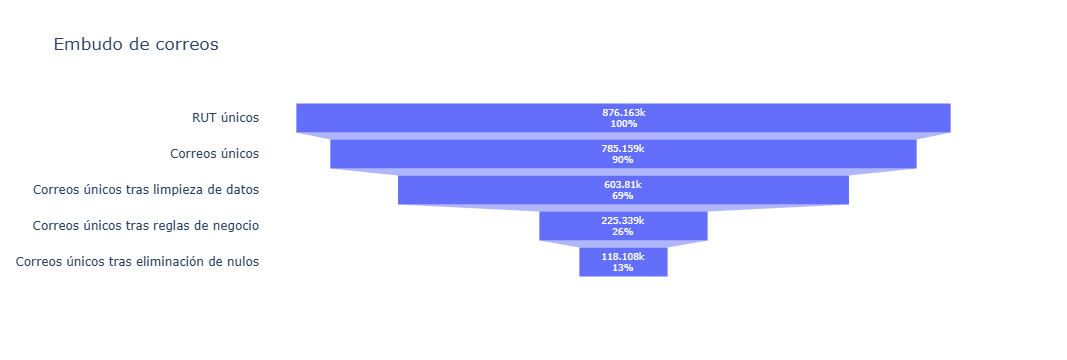

In [3]:
import plotly.graph_objects as go

# Lista de valores y etiquetas proporcionadas (de mayor a menor)
valores = [876163, 785159, 603810, 225339,118108]

etapas = [
    'RUT únicos',
    'Correos únicos',
    'Correos únicos tras limpieza de datos',
    'Correos únicos tras reglas de negocio',
    'Correos únicos tras eliminación de nulos'
]

# Crear el diagrama de embudo
fig = go.Figure(go.Funnel(
    y = etapas,
    x = valores,
    textinfo = "value+percent initial",
    hovertemplate='%{x:,.0f}<extra>%{percentInitial:.2%}</extra>',  # Mostrar los valores completos sin 'k' ni formato abreviado
))

# Actualizar layout para fondo blanco
fig.update_layout(
    title='Embudo de correos',
    funnelmode='stack',
    plot_bgcolor='white'  # Cambiar el color de fondo a blanco
)


fig.show()


#### **Codigos de la distribución de los datos**

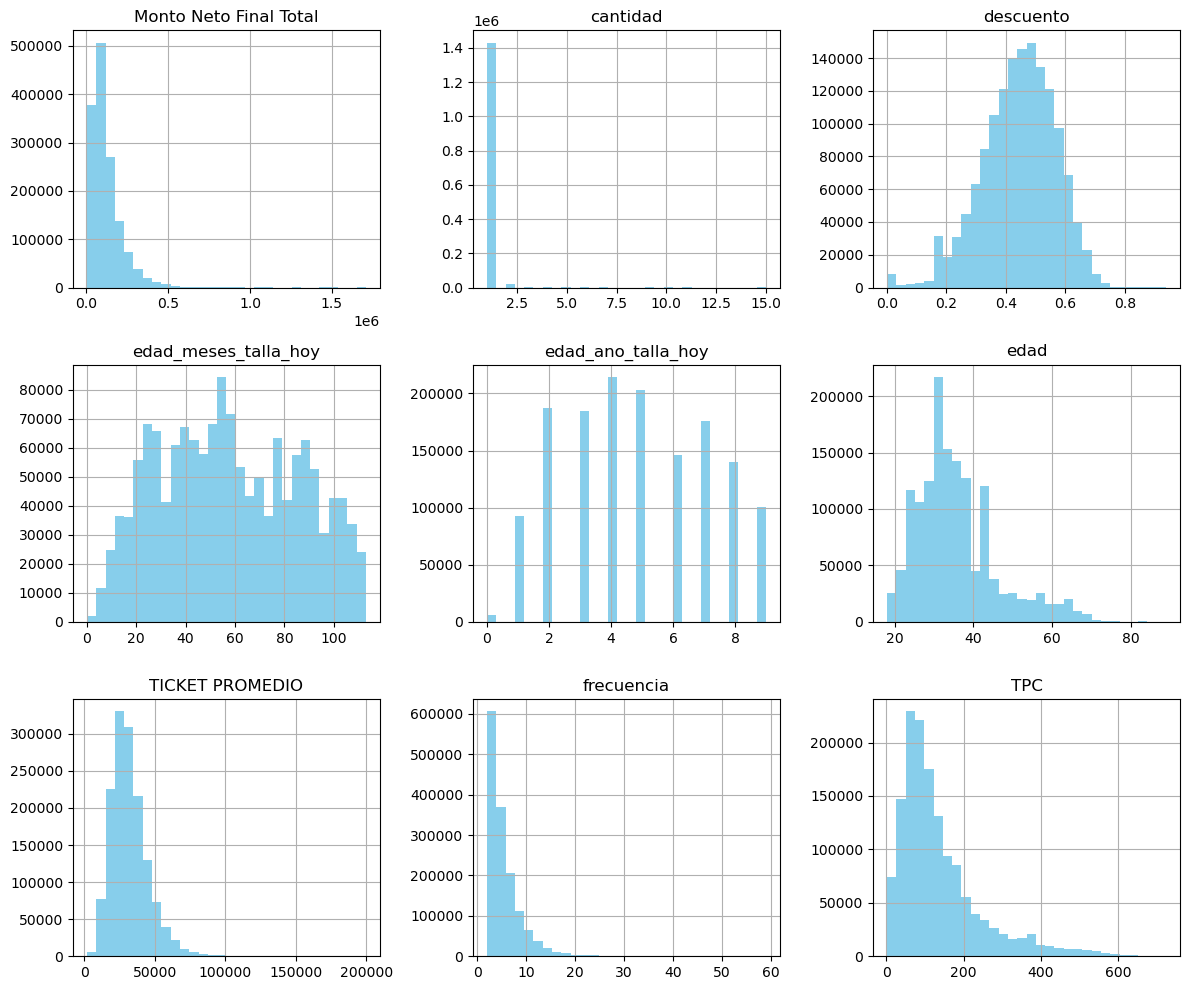

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
num_cols = ["Monto Neto Final Total", "cantidad", "descuento", "edad_meses_talla_hoy", "edad_ano_talla_hoy","edad","TICKET PROMEDIO","frecuencia","TPC"]
df_final_1[num_cols].hist(figsize=(12, 10), bins=30, color='skyblue')
plt.tight_layout()
plt.show()

Procedemos a eliminar las filas de transacciones que presentan valores nulos, o 'NaN'

In [10]:
print(df_final_2.head())

       fecha    boleta  montoneto    marca  cantidad        area  \
0 2023-02-04  23591771    36126.0  COLLOKY         1     CALZADO   
1 2023-09-24  24719633    29403.0  COLLOKY         1     CALZADO   
2 2023-02-10  23592465     3358.0  COLLOKY         1        ROPA   
3 2023-02-10  23592465     3022.0  COLLOKY         1  ACCESORIOS   
4 2023-02-15  23689167     5038.0  COLLOKY         1        ROPA   

      temporada         correo genero    canal  edad  porcentaje_descuento  \
0  INVIERNO2023  ---@gmail.com    BOY  OFFLINE  64.0                   0.0   
1    VERANO2024  ---@gmail.com    BOY  OFFLINE  64.0                   0.0   
2    VERANO2023    -@gmail.com   GIRL  OFFLINE  35.0                   0.0   
3    VERANO2023    -@gmail.com   GIRL  OFFLINE  35.0                   0.0   
4    VERANO2023    -@gmail.com   GIRL  OFFLINE  35.0                   0.0   

   edad_meses_talla_hoy  edad_ano_talla_hoy  TICKET PROMEDIO INICIO  \
0                  51.0                 4.0        

In [4]:
# Contar las filas que tienen al menos un valor NaN o nulo antes de eliminar
missing_rows = df_final_1.isna().sum(axis=1)
total_missing_rows = (missing_rows > 0).sum()

# Eliminar las filas con valores NaN o nulos en cualquier columna y asignarlo a df_final_4
df_final_2 = df_final_1.dropna()

# Imprimir el total de filas con valores NaN o vacíos antes de eliminar
print(f"Total de filas con valores nulos o vacíos en alguna columna: {total_missing_rows}")

# Imprimir el número total de filas restantes después de eliminar las filas con NaN o nulos
print(f"Total de filas después de eliminar filas con valores nulos o vacíos: {df_final_2.shape[0]}")



Total de filas con valores nulos o vacíos en alguna columna: 551117
Total de filas después de eliminar filas con valores nulos o vacíos: 1765949


#### **Método del codo**

Procedemos a aplicar el 'método del codo' para saber que cantidad de cluster tomaremos en nuestro modelo.

En este caso, le decimos que agrupe todo por correos únicos, y que considere las columnas de ticket promedio y tiempo promedio entre compra para el modelo.

Finalmente, al ver el gráfico, tomamos la decisión de tomar 6 clusters.

correo              object
TPC                float64
TICKET PROMEDIO    float64
dtype: object
(267169, 3)
                      correo    TPC  TICKET PROMEDIO
0              ---@gmail.com  232.0        38989.755
1                -@gmail.com    5.0        10949.428
2                .@gmail.com   69.0        19470.066
3   .bravo.sanchez@gmail.com  122.5        25866.078
4  .rojasmaldonado@gmail.com   86.0        14990.430
TPC                0
TICKET PROMEDIO    0
dtype: int64
TPC                0
TICKET PROMEDIO    0
dtype: int64


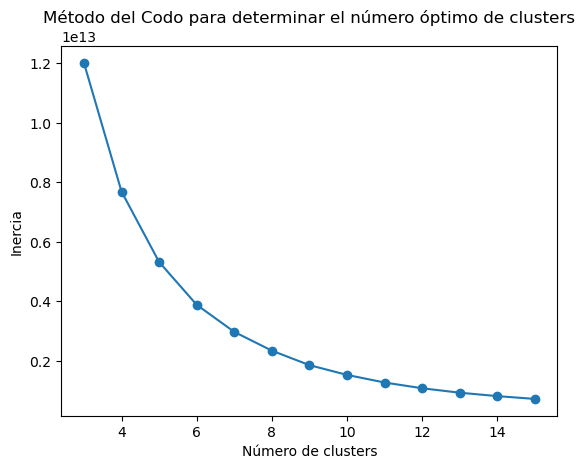

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster

# Agrupar por correo y calcular el promedio de 'TPC' y 'TICKET PROMEDIO'
df_grouped = df_final_2.groupby('correo')[['TPC', 'TICKET PROMEDIO']].mean().reset_index()

# Verificar los tipos de datos y la forma del DataFrame
print(df_grouped.dtypes)
print(df_grouped.shape)  # Comprobar la forma después del agrupamiento
print(df_grouped.head())  # Verificar los primeros datos

# Seleccionar solo las columnas 'TPC' y 'TICKET PROMEDIO' para el análisis de clustering
df_selected = df_grouped[['TPC', 'TICKET PROMEDIO']]

# Verificar si hay valores NaN o infinitos
print(df_selected.isna().sum())  # Para verificar si hay NaN
print(np.isinf(df_selected).sum())  # Para verificar si hay valores infinitos

# Lista para almacenar las inercia (codo)
inertias = []
K = range(3, 16)

# Ejecutar KMeans para diferentes valores de k
for k in K:
    kmeans = cluster.KMeans(n_clusters=k, random_state=1, init="k-means++", n_init="auto")
    kmeans.fit(df_selected)  # Usar las columnas seleccionadas
    inertias.append(kmeans.inertia_)

# Graficar el codo
plt.plot(K, inertias, marker='o')
plt.title("Método del Codo para determinar el número óptimo de clusters")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")

# Guardar el gráfico como una imagen de alta calidad en la ruta especificada
plt.savefig(r"C:\Users\constanza.perez\OneDrive - Colgram\Escritorio\metodo_del_codo.png", dpi=300)

# Mostrar el gráfico
plt.show()


In [6]:
clusters = 6

#### **Implementación modelo KMeans**

Procedemos a ocupar el modelo KMeans, y visulizamos en un gráfico la distribución de los clusters y sus centroides

Procedemos a escalar TPC y ticket promedio para obtener que ambas variables tengan la misma importancia.

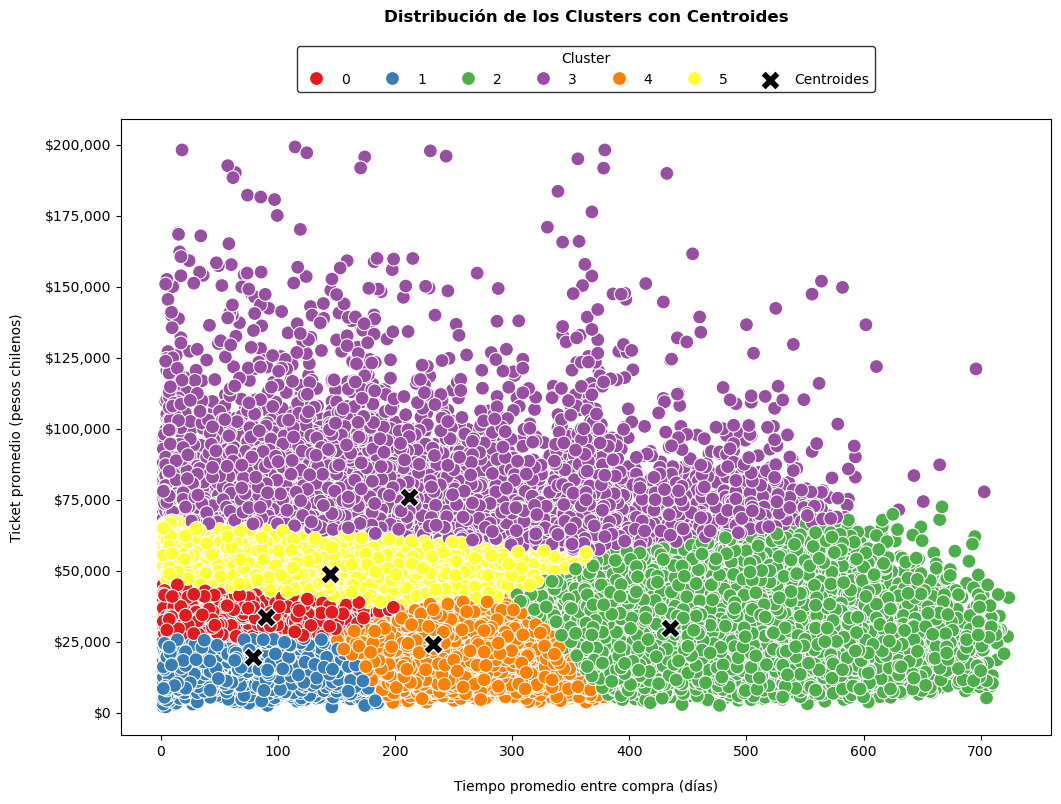

Cluster,Correo_Únicos,Min TPC,Max TPC,Min TICKET PROMEDIO,Max TICKET PROMEDIO,cantidad_x,area_x,genero_x,canal_x,edad_x,edad_ano_talla_hoy_x,frecuencia,descuento
0,36819,2,206,"$26,043","$46,174",1.010,"MIXTO: 53%, ROPA: 25%, CALZADO: 21%","GIRL: 40%, BOY: 31%, MIXTO: 27%, Sin Genero: 1%","OFFLINE: 85%, MIXTO: 10%, ONLINE: 5%",35.0,5.5,3,32.70%
1,27885,2,190,"$2,990","$27,457",1.009,"MIXTO: 46%, ROPA: 35%, CALZADO: 19%","GIRL: 40%, BOY: 34%, MIXTO: 24%, Sin Genero: 2%","OFFLINE: 79%, MIXTO: 12%, ONLINE: 9%",34.4,5.1,6,39.72%
2,9612,302,716,"$3,490","$69,838",1.010,"ROPA: 45%, CALZADO: 39%, MIXTO: 16%","GIRL: 46%, BOY: 40%, MIXTO: 9%, Sin Genero: 5%","OFFLINE: 88%, ONLINE: 10%, MIXTO: 1%",35.3,5.7,2,35.48%
3,4281,2,696,"$56,158","$198,156",1.093,"CALZADO: 40%, MIXTO: 33%, ROPA: 27%","GIRL: 43%, BOY: 29%, MIXTO: 25%, Sin Genero: 3%","OFFLINE: 86%, ONLINE: 8%, MIXTO: 5%",36.1,6.6,3,18.39%
4,18875,146,381,"$3,843","$40,983",1.009,"ROPA: 45%, CALZADO: 33%, MIXTO: 22%","GIRL: 45%, BOY: 39%, MIXTO: 12%, Sin Genero: 3%","OFFLINE: 86%, ONLINE: 10%, MIXTO: 4%",34.8,5.4,5,38.24%
5,20636,2,377,"$37,380","$67,609",1.020,"MIXTO: 45%, CALZADO: 30%, ROPA: 25%","GIRL: 42%, BOY: 31%, MIXTO: 24%, Sin Genero: 2%","OFFLINE: 87%, MIXTO: 7%, ONLINE: 6%",35.6,5.9,3,27.70%


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Agrupar por correo y calcular el promedio de 'TPC' y 'TICKET PROMEDIO'
df_grouped = df_final_2.groupby('correo')[['TPC', 'TICKET PROMEDIO']].mean().reset_index()

# Seleccionar solo las columnas 'TPC' y 'TICKET PROMEDIO' para el análisis de clustering
df_selected = df_grouped[['TPC', 'TICKET PROMEDIO']]

# Asegurarse de que las columnas seleccionadas sean numéricas
df_selected = df_selected.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores NaN (si es necesario)
df_selected = df_selected.dropna()

# Escalar las variables 'TPC' y 'TICKET PROMEDIO'
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected[['TPC', 'TICKET PROMEDIO']])

# Ajustar el modelo KMeans con 6 clusters usando los datos escalados
kmeans = KMeans(n_clusters=6, random_state=1, init="k-means++", n_init="auto")
kmeans.fit(df_scaled)

# Agregar los labels (asignación de clusters) al DataFrame
df_selected['Cluster'] = kmeans.labels_

# Obtener los centroides de los clusters (en escala original)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Graficar la distribución de los clusters con centroides
plt.figure(figsize=(12, 8))  # Ampliar la figura para mayor claridad

# Gráfico de dispersión con los clusters coloreados
sns.scatterplot(data=df_selected, x='TPC', y='TICKET PROMEDIO', hue='Cluster', palette='Set1', s=100, marker='o', legend='full')

# Añadir los centroides al gráfico (desescalados)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, marker='X', label='Centroides', edgecolor='white')

# Personalizar el gráfico
plt.title("Distribución de los Clusters con Centroides", pad=70, fontweight='bold')  # Añadir negrita al título
plt.xlabel("Tiempo promedio entre compra (días)", labelpad=15)
plt.ylabel("Ticket promedio (pesos chilenos)", labelpad=15)

# Ajustar la leyenda con recuadro negro
legend = plt.legend(title="Cluster", loc="upper center", bbox_to_anchor=(0.5, 1.13), ncol=7, frameon=True)
legend.get_frame().set_edgecolor('black')

# Formatear los valores del eje y
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))

# Formatear los valores del eje x
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x).replace(',', '.')))

plt.show()

# Agregar la columna 'Cluster' a df_selected con las variables 'TPC' y 'TICKET PROMEDIO'
df_selected = df_selected[['TPC', 'TICKET PROMEDIO', 'Cluster']]

# Reducir el tamaño del conjunto de datos (usa solo el 10% de los datos originales)
df_final_2_sample = df_final_2.sample(frac=0.1, random_state=1)

# Agregar la columna 'Cluster' a df_final_2 usando las variables 'TPC' y 'TICKET PROMEDIO'
df_final_2_sample = df_final_2_sample.merge(df_selected, on=['TPC', 'TICKET PROMEDIO'], how='left')

# Unir df_final_2_sample con df_unificado usando 'correo' para asegurarnos de tener todas las columnas necesarias
df_resultado = df_final_2_sample.merge(df_unificado, on='correo', how='left')

# Función para categorizar áreas, géneros y canales, incluyendo la condición especial para ACCESORIOS
def categorize_column(column_values):
    unique_values = column_values.unique()
    if len(unique_values) == 1:
        return 'ROPA' if unique_values[0] == 'ACCESORIOS' else unique_values[0]
    else:
        return 'MIXTO'

# Aplicar la función de categorización
df_resultado['area_x'] = df_resultado.groupby('correo')['area_x'].transform(categorize_column)
df_resultado['genero_x'] = df_resultado.groupby('correo')['genero_x'].transform(categorize_column)
df_resultado['canal_x'] = df_resultado.groupby('correo')['canal_x'].transform(categorize_column)

# Calcular el conteo de correos únicos por cluster
unique_emails_per_cluster = df_resultado.groupby('Cluster')['correo'].nunique().reset_index()
unique_emails_per_cluster.columns = ['Cluster', 'Correo_Únicos']

# Calcular el rango de TPC y TICKET PROMEDIO por cluster
ranges = df_resultado.groupby('Cluster').agg({
    'TPC': ['min', 'max'],
    'TICKET PROMEDIO': ['min', 'max']
}).reset_index()
ranges.columns = ['Cluster', 'Min TPC', 'Max TPC', 'Min TICKET PROMEDIO', 'Max TICKET PROMEDIO']

# Unir los conteos de correos y los rangos
cluster_info = pd.merge(unique_emails_per_cluster, ranges, on='Cluster')

# Función para formatear los porcentajes sin decimales ni puntos
def format_percentage_without_decimals(column_values):
    return ', '.join([f"{value}: {int(round((count / len(column_values)) * 100))}%" for value, count in column_values.value_counts().items()])

# Calcular las medias y porcentajes por categoría para cada cluster
additional_stats = df_resultado.groupby('Cluster').agg({
    'cantidad_x': 'mean',
    'area_x': lambda x: format_percentage_without_decimals(x),
    'genero_x': lambda x: format_percentage_without_decimals(x),
    'canal_x': lambda x: format_percentage_without_decimals(x),
    'edad_x': 'mean',
    'edad_ano_talla_hoy_x': 'mean',
    'frecuencia': 'first',
    'descuento': 'mean'  # Agregar descuento_final a las estadísticas adicionales
}).reset_index()

# Unir la información adicional al DataFrame de clusters
cluster_info = pd.merge(cluster_info, additional_stats, on='Cluster')

# Formatear las columnas según lo solicitado
cluster_info['Cluster'] = cluster_info['Cluster'].map(lambda x: f"{x:.0f}")
cluster_info['Min TPC'] = cluster_info['Min TPC'].map(lambda x: f"{x:,.0f}")
cluster_info['Max TPC'] = cluster_info['Max TPC'].map(lambda x: f"{x:,.0f}")
cluster_info['Min TICKET PROMEDIO'] = cluster_info['Min TICKET PROMEDIO'].map(lambda x: f"${x:,.0f}")
cluster_info['Max TICKET PROMEDIO'] = cluster_info['Max TICKET PROMEDIO'].map(lambda x: f"${x:,.0f}")
cluster_info['cantidad_x'] = cluster_info['cantidad_x'].map(lambda x: f"{x:,.3f}")
cluster_info['edad_x'] = cluster_info['edad_x'].map(lambda x: f"{x:,.1f}")
cluster_info['edad_ano_talla_hoy_x'] = cluster_info['edad_ano_talla_hoy_x'].map(lambda x: f"{x:,.1f}")
cluster_info['descuento'] = cluster_info['descuento'].map(lambda x: f"{x * 100:.2f}%")  # Formatear descuento_final como porcentaje con dos decimales


# Añadir colores de clusters
colors = sns.color_palette("Set1", n_colors=6).as_hex()
cluster_info['Color'] = cluster_info['Cluster'].map(lambda x: colors[int(x)])

# Función para crear iconos de colores en HTML
def create_color_icon(color):
    return f'<svg height="15" width="15"><circle cx="7.5" cy="7.5" r="7.5" fill="{color}" /></svg>'

# Añadir icono de color al nombre del cluster
cluster_info['Cluster'] = cluster_info.apply(lambda row: f'{create_color_icon(row["Color"])} {row["Cluster"]}', axis=1)

# Eliminar la columna de color antes de mostrar
cluster_info = cluster_info.drop(columns=['Color'], errors='ignore')

# Mostrar la información de cada cluster en formato de tabla
from IPython.display import display, HTML

# Convertir el DataFrame a HTML para mejor visualización
display(HTML(cluster_info.to_html(index=False, escape=False)))


### **Apertura Cluster 'Medio Valor' (0 y 1)**

In [8]:
# Reducir el tamaño del conjunto de datos (usa solo el 10% de los datos originales)
df_final_2_sample = df_final_2.sample(frac=0.1, random_state=1)

# Agregar la columna 'Cluster' a df_final_2 usando las variables 'TPC' y 'TICKET PROMEDIO'
df_final_2_sample = df_final_2_sample.merge(df_selected, on=['TPC', 'TICKET PROMEDIO'], how='left')

# Unir df_final_2_sample con df_unificado usando 'correo' para asegurarnos de tener todas las columnas necesarias
df_resultado = df_final_2_sample.merge(df_unificado, on='correo', how='left')

# Verificar que la columna 'Cluster' exista después de la fusión
if 'Cluster' in df_resultado.columns:
    df_final_2 = df_resultado.copy()  # Actualizar df_final_2 con df_resultado
    # Filtrar por los clusters 2, 3 y 5
    clusters_filtrados = df_final_2[df_final_2['Cluster'].isin([0,1])]
    
    # Conteo de correos únicos por cluster
    conteo_rut_unicos = clusters_filtrados.groupby('Cluster')['correo'].nunique()
    print("Conteo de rut únicos por cluster:")
    print(conteo_rut_unicos)

    # Total de correos únicos en los clusters seleccionados
    total_correos_unicos = clusters_filtrados['correo'].nunique()
    print(f"\nTotal de correos únicos en los clusters seleccionados: {total_correos_unicos}")
else:
    print("Error: La columna 'Cluster' no existe en el DataFrame.")


Conteo de rut únicos por cluster:
Cluster
0.0    36819
1.0    27885
Name: correo, dtype: int64

Total de correos únicos en los clusters seleccionados: 64704


In [9]:
# Seleccionar solo las columnas deseadas
columnas_deseadas = ['cantidad_x', 'area_x','correo', 'genero_x', 'canal_x', 'edad_x', 
                     'descuento', 'edad_ano_talla_hoy_x',
                     'frecuencia']

df_resultado = df_resultado.loc[:, columnas_deseadas]


In [11]:
import pandas as pd
import numpy as np

# Agrupar por correo y aplicar las condiciones especificadas
df_resultado = df_final_2[df_final_2['Cluster'].isin([0,1])].groupby('correo').agg({
    'cantidad_x': 'mean',
    'area_x': lambda x: 'CALZADO' if all(y == 'CALZADO' for y in x) else ('ROPA' if all(y in ['ROPA', 'ACCESORIOS'] for y in x) else 'MIXTO'),
    'genero_x': lambda x: 'BOY' if all(y == 'BOY' for y in x) else ('GIRL' if all(y == 'GIRL' for y in x) else ('Sin Genero' if all(y == 'Sin Genero' for y in x) else 'MIXTO')),
    'canal_x': lambda x: 'OFFLINE' if all(y == 'OFFLINE' for y in x) else ('ONLINE' if all(y == 'ONLINE' for y in x) else 'OMNICANAL'),
    'edad_x': 'mean',
    'descuento': 'mean',
    'edad_ano_talla_hoy_x': 'mean', 
    'frecuencia': 'first'       # Asumiendo que ya está calculado por correo único
}).reset_index()



# Contar el número de correos únicos
conteo_correos_unicos = df_resultado['correo'].nunique()

# Mostrar el conteo de correos únicos
print(f"Conteo de correos únicos: {conteo_correos_unicos}")

# Contar el número total de filas en el DataFrame resultante
conteo_filas_totales = len(df_resultado)

# Mostrar el conteo total de filas
print(f"Conteo total de filas: {conteo_filas_totales}")


Conteo de correos únicos: 64704
Conteo total de filas: 64704


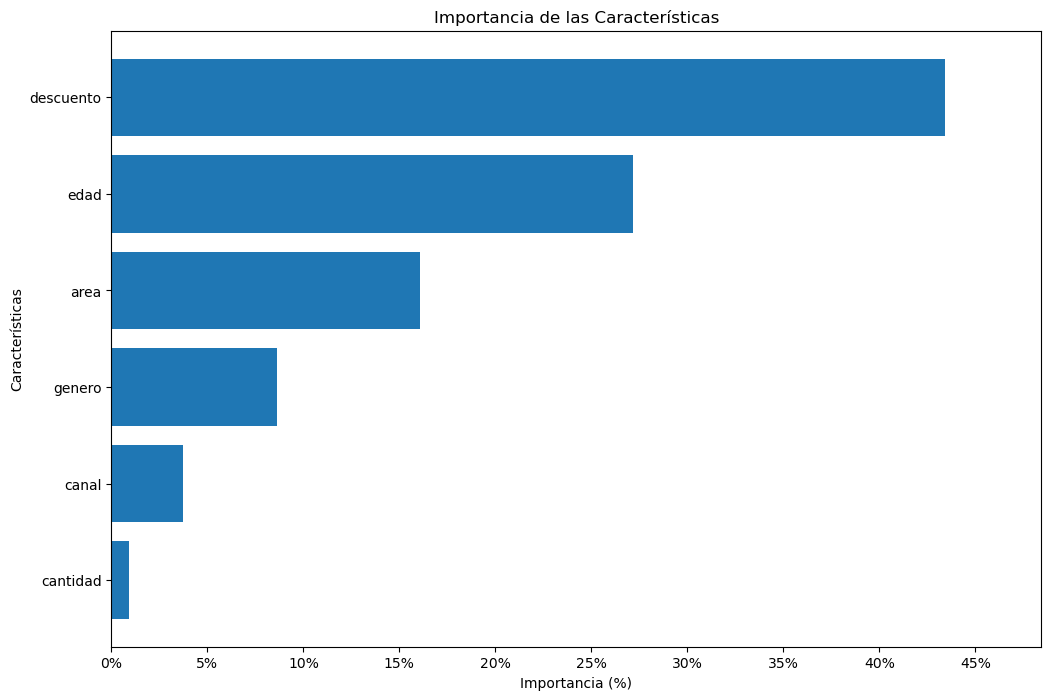

In [12]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que df_resultado ya está definido y contiene los datos procesados
df_resultado = df_resultado  # Asegúrate de que df_resultado esté correctamente definido

# Seleccionar las características (features) y la variable objetivo (target)
columns_to_keep = ['cantidad_x', 'area_x', 'genero_x', 'canal_x', 'edad_x', 'descuento', 'edad_ano_talla_hoy_x']
features = df_resultado[columns_to_keep]
target = df_resultado['frecuencia']

# Filtrar valores de 'porcentaje_descuento_x' fuera del rango [0, 1]
features = features[(features['descuento'] >= 0) & (features['descuento'] <= 1)]

# Codificar variables categóricas como numéricas
features = pd.get_dummies(features)
target = pd.factorize(target)[0]

# Filtrar valores extremos solo en las columnas numéricas
num_cols = features.select_dtypes(include=[np.number]).columns
features[num_cols] = features[num_cols].apply(lambda x: np.clip(x, a_min=x.quantile(0.01), a_max=x.quantile(0.99)))

# Calcular la matriz de correlación y eliminar características altamente correlacionadas
correlation_matrix = features.corr()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.9)]
features = features.drop(columns=to_drop)

# Verificar y limpiar los datos (eliminar valores nulos y tipos inconsistentes)
features.dropna(inplace=True)

# Alinear el target con las características después de eliminar valores nulos
target = target[:len(features)]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Crear el modelo de árbol de decisión con una profundidad máxima
clf = DecisionTreeClassifier(random_state=42, max_depth=10)
clf.fit(X_train, y_train)

# Obtener la importancia de las características
importances = clf.feature_importances_
feature_names = features.columns

# Agrupar las características en categorías principales
feature_names_grouped = feature_names.str.split('_').str[0]

# Crear un DataFrame para la importancia de las características
feature_importance_df = pd.DataFrame({'Feature': feature_names_grouped, 'Importance': importances})
feature_importance_df = feature_importance_df.groupby('Feature').sum().sort_values(by='Importance', ascending=False)

# Filtrar las características más importantes (por ejemplo, las 10 principales)
top_features = feature_importance_df.head(10)

# Visualizar la importancia de las características más importantes
plt.figure(figsize=(12, 8))
plt.barh(top_features.index, top_features['Importance'] * 100)  # Convertir a porcentaje
plt.xlabel('Importancia (%)')  # Modificar etiqueta del eje X
max_importance = top_features['Importance'].max() * 100  # Calcular el valor máximo de importancia
plt.xlim(0, max_importance + 5)  # Establecer el límite del eje X ligeramente por encima del valor máximo
plt.xticks(ticks=np.arange(0, max_importance + 6, 5), labels=[f'{int(i)}%' for i in np.arange(0, max_importance + 6, 5)])  # Añadir % en el eje X sin decimales
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.gca().invert_yaxis()
plt.show()


correo        object
edad_x       float64
descuento    float64
dtype: object
(64704, 3)
                         correo  edad_x  descuento
0                   .@gmail.com    30.0   0.304392
1      .bravo.sanchez@gmail.com    56.0   0.050823
2     .rojasmaldonado@gmail.com    36.0   0.000000
3           01.rojasp@gmail.com    47.5   0.195782
4  0101tamaraenriquez@gmail.com    22.0   0.434377
correo       0
edad_x       0
descuento    0
dtype: int64
correo       0
edad_x       0
descuento    0
dtype: int64
[[-0.39610723 -0.32844586]
 [ 1.852989   -2.15165925]
 [ 0.12291498 -2.51708346]
 ...
 [-0.65561833  0.81046722]
 [-0.56911463  0.51830157]
 [ 0.98795199  1.4076204 ]]


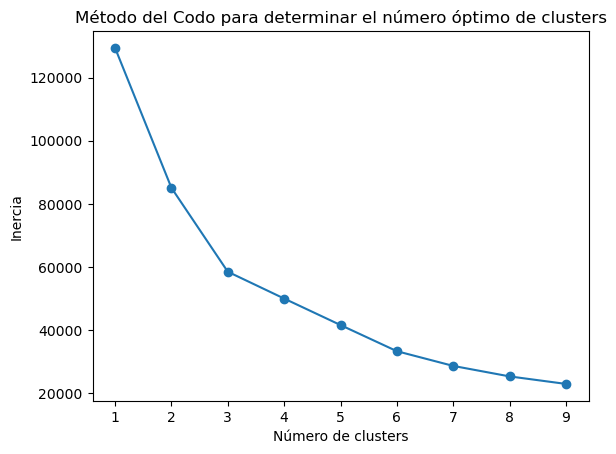

Número de filas: 64704, Correos únicos: 64704


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler

# Agrupar por correo y calcular el promedio de 'edad_x', 'edad_ano_talla_hoy_x' y 'porcentaje_descuento_x'
df_grouped = df_resultado.groupby('correo')[['edad_x', 'descuento']].mean().reset_index()

# Verificar los tipos de datos y la forma del DataFrame
print(df_grouped.dtypes)
print(df_grouped.shape)  # Comprobar la forma después del agrupamiento
print(df_grouped.head())  # Verificar los primeros datos

# Filtrar valores de 'porcentaje_descuento_x' fuera del rango [0, 1]
df_grouped = df_grouped[(df_grouped['descuento'] >= 0) & (df_grouped['descuento'] <= 1)]

# Verificar si hay valores NaN, infinitos o negativos infinitos
print(df_grouped.isna().sum())
print(df_grouped.isin([np.nan, np.inf, -np.inf]).sum())

# Eliminar filas con valores NaN o infinitos
df_grouped = df_grouped.dropna()
df_grouped = df_grouped.replace([np.inf, -np.inf], np.nan).dropna()

# Asegurarse de que las columnas sean numéricas
df_grouped['edad_x'] = pd.to_numeric(df_grouped['edad_x'])
df_grouped['descuento'] = pd.to_numeric(df_grouped['descuento'])

# Seleccionar solo las columnas 'edad_x', 'edad_ano_talla_hoy_x' y 'porcentaje_descuento_x' para el análisis de clustering
df_selected = df_grouped[['edad_x', 'descuento']]

# Normalizar los datos
scaler = StandardScaler()
df_selected_scaled = scaler.fit_transform(df_selected)

# Verificar el contenido de df_selected_scaled
print(df_selected_scaled)

# Lista para almacenar las inercia (codo)
inertias = []
K = range(1, 10)  # Ajustar el rango de K para más clusters

# Ejecutar KMeans para diferentes valores de k con manejo de errores
try:
    for k in K:
        kmeans = cluster.KMeans(n_clusters=k, random_state=1, init="k-means++", n_init="auto")
        kmeans.fit(df_selected_scaled)  # Usar las columnas seleccionadas y normalizadas
        inertias.append(kmeans.inertia_)
except ValueError as e:
    print(f"Error with k={k}: {e}")

# Graficar el codo
if inertias:
    plt.plot(K, inertias, marker='o')
    plt.title("Método del Codo para determinar el número óptimo de clusters")
    plt.xlabel("Número de clusters")
    plt.ylabel("Inercia")
    plt.show()

# Obtener el número de filas del dataframe y el conteo de correos únicos
num_filas = df_resultado.shape[0]
correos_unicos = df_resultado['correo'].nunique()
print(f"Número de filas: {num_filas}, Correos únicos: {correos_unicos}")


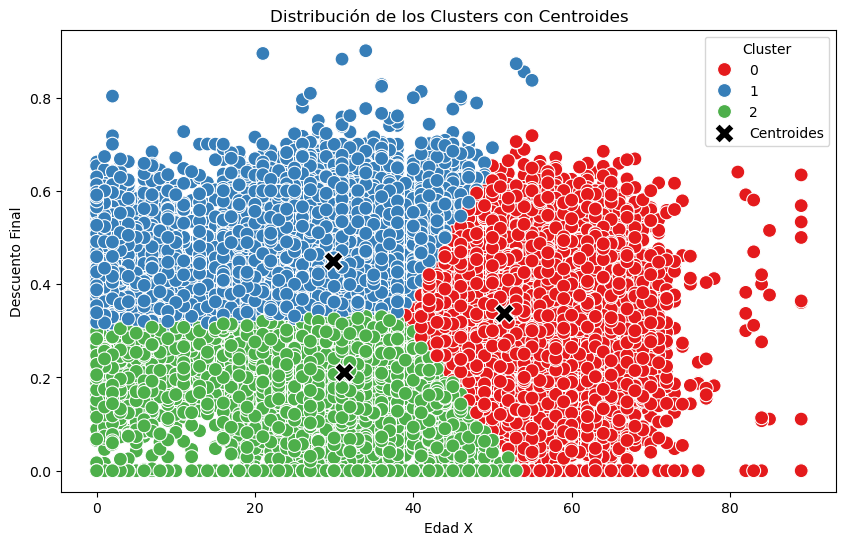

Cluster 1:
Rango de edad_x: 39.0 - 89.0
Rango de descuento_final: 0.0% - 71.8%

Cluster 2:
Rango de edad_x: 0.0 - 55.0
Rango de descuento_final: 30.5% - 90.0%

Cluster 3:
Rango de edad_x: 0.0 - 53.0
Rango de descuento_final: 0.0% - 33.7%

   Cluster  Edad X Min  Edad X Max Descuento Final Min Descuento Final Max
0        1        39.0        89.0                0.0%               71.8%
1        2         0.0        55.0               30.5%               90.0%
2        3         0.0        53.0                0.0%               33.7%


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Agrupar por correo y calcular el promedio de 'edad_x' y 'descuento_final'
df_grouped = df_resultado.groupby('correo')[['edad_x', 'descuento']].mean().reset_index()

# Seleccionar solo las columnas 'edad_x' y 'descuento_final' para el análisis de clustering
df_selected = df_grouped[['edad_x', 'descuento']]

# Asegurarse de que las columnas seleccionadas sean numéricas
df_selected = df_selected.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores NaN (si es necesario)
df_selected = df_selected.dropna()

# Escalar las variables 'edad_x' y 'descuento_final'
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected[['edad_x', 'descuento']])

# Ajustar el modelo KMeans con 3 clusters usando los datos escalados
kmeans = KMeans(n_clusters=3, random_state=1, init="k-means++", n_init="auto")
kmeans.fit(df_scaled)

# Agregar los labels (asignación de clusters) al DataFrame
df_selected['Cluster'] = kmeans.labels_

# Obtener los centroides de los clusters (en escala original)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Graficar la distribución de los clusters con centroides
plt.figure(figsize=(10, 6))

# Gráfico de dispersión con los clusters coloreados
sns.scatterplot(data=df_selected, x='edad_x', y='descuento', hue='Cluster', palette='Set1', s=100, marker='o', legend='full')

# Añadir los centroides al gráfico (desescalados)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, marker='X', label='Centroides', edgecolor='white')

# Personalizar el gráfico
plt.title("Distribución de los Clusters con Centroides")
plt.xlabel("Edad X")
plt.ylabel("Descuento Final")
plt.legend(title="Cluster")
plt.show()

# Reducir el tamaño del conjunto de datos (usa solo el 10% de los datos originales)
df_resultado_sample = df_resultado.sample(frac=0.1, random_state=1)

# Agregar la columna 'Cluster' a df_resultado usando las variables 'edad_x' y 'descuento_final'
df_resultado = df_resultado_sample.merge(df_selected[['edad_x', 'descuento', 'Cluster']], on=['edad_x', 'descuento'], how='left')

# Rango de edades para cada cluster
for cluster_num in range(kmeans.n_clusters):
    cluster_data = df_selected[df_selected['Cluster'] == cluster_num]
    edad_x_min = cluster_data['edad_x'].min()
    edad_x_max = cluster_data['edad_x'].max()
    descuento_final_min = cluster_data['descuento'].min()
    descuento_final_max = cluster_data['descuento'].max()
    print(f"Cluster {cluster_num + 1}:")
    print(f"Rango de edad_x: {edad_x_min} - {edad_x_max}")
    print(f"Rango de descuento_final: {descuento_final_min*100:.1f}% - {descuento_final_max*100:.1f}%")
    print("")

# Opción alternativa: Mostrar en formato de tabla
cluster_ranges = []
for cluster_num in range(kmeans.n_clusters):
    cluster_data = df_selected[df_selected['Cluster'] == cluster_num]
    edad_x_min = cluster_data['edad_x'].min()
    edad_x_max = cluster_data['edad_x'].max()
    descuento_final_min = cluster_data['descuento'].min()
    descuento_final_max = cluster_data['descuento'].max()
    rango_descuento_final_min = f"{descuento_final_min*100:.1f}%"
    rango_descuento_final_max = f"{descuento_final_max*100:.1f}%"
    cluster_ranges.append([cluster_num + 1, edad_x_min, edad_x_max, rango_descuento_final_min, rango_descuento_final_max])

df_cluster_ranges = pd.DataFrame(cluster_ranges, columns=['Cluster', 'Edad X Min', 'Edad X Max', 'Descuento Final Min', 'Descuento Final Max'])
print(df_cluster_ranges)


### **Apertura Cluster 'Alto Valor' (3)**

In [7]:
# Reducir el tamaño del conjunto de datos (usa solo el 10% de los datos originales)
df_final_2_sample = df_final_2.sample(frac=0.1, random_state=1)

# Agregar la columna 'Cluster' a df_final_2 usando las variables 'TPC' y 'TICKET PROMEDIO'
df_final_2_sample = df_final_2_sample.merge(df_selected, on=['TPC', 'TICKET PROMEDIO'], how='left')

# Unir df_final_2_sample con df_unificado usando 'correo' para asegurarnos de tener todas las columnas necesarias
df_resultado = df_final_2_sample.merge(df_unificado, on='correo', how='left')

# Verificar que la columna 'Cluster' exista después de la fusión
if 'Cluster' in df_resultado.columns:
    df_final_2 = df_resultado.copy()  # Actualizar df_final_2 con df_resultado
    # Filtrar por los clusters 2, 3 y 5
    clusters_filtrados = df_final_2[df_final_2['Cluster'].isin([3])]
    
    # Conteo de correos únicos por cluster
    conteo_rut_unicos = clusters_filtrados.groupby('Cluster')['correo'].nunique()
    print("Conteo de rut únicos por cluster:")
    print(conteo_rut_unicos)

    # Total de correos únicos en los clusters seleccionados
    total_correos_unicos = clusters_filtrados['correo'].nunique()
    print(f"\nTotal de correos únicos en los clusters seleccionados: {total_correos_unicos}")
else:
    print("Error: La columna 'Cluster' no existe en el DataFrame.")


Conteo de rut únicos por cluster:
Cluster
3.0    4281
Name: correo, dtype: int64

Total de correos únicos en los clusters seleccionados: 4281


In [8]:
# Seleccionar solo las columnas deseadas
columnas_deseadas = ['cantidad_x', 'area_x','correo', 'genero_x', 'canal_x', 'edad_x', 
                     'descuento', 'edad_ano_talla_hoy_x',
                     'frecuencia']

df_resultado = df_resultado.loc[:, columnas_deseadas]


In [9]:
import pandas as pd
import numpy as np

# Agrupar por correo y aplicar las condiciones especificadas
df_resultado = df_final_2[df_final_2['Cluster'].isin([3])].groupby('correo').agg({
    'cantidad_x': 'mean',
    'area_x': lambda x: 'CALZADO' if all(y == 'CALZADO' for y in x) else ('ROPA' if all(y in ['ROPA', 'ACCESORIOS'] for y in x) else 'MIXTO'),
    'genero_x': lambda x: 'BOY' if all(y == 'BOY' for y in x) else ('GIRL' if all(y == 'GIRL' for y in x) else ('Sin Genero' if all(y == 'Sin Genero' for y in x) else 'MIXTO')),
    'canal_x': lambda x: 'OFFLINE' if all(y == 'OFFLINE' for y in x) else ('ONLINE' if all(y == 'ONLINE' for y in x) else 'OMNICANAL'),
    'edad_x': 'mean',
    'descuento': 'mean',
    'edad_ano_talla_hoy_x': 'mean', 
    'frecuencia': 'first'       # Asumiendo que ya está calculado por correo único
}).reset_index()

# Contar el número de correos únicos
conteo_correos_unicos = df_resultado['correo'].nunique()

# Mostrar el conteo de correos únicos
print(f"Conteo de correos únicos: {conteo_correos_unicos}")

# Contar el número total de filas en el DataFrame resultante
conteo_filas_totales = len(df_resultado)

# Mostrar el conteo total de filas
print(f"Conteo total de filas: {conteo_filas_totales}")


Conteo de correos únicos: 4281
Conteo total de filas: 4281


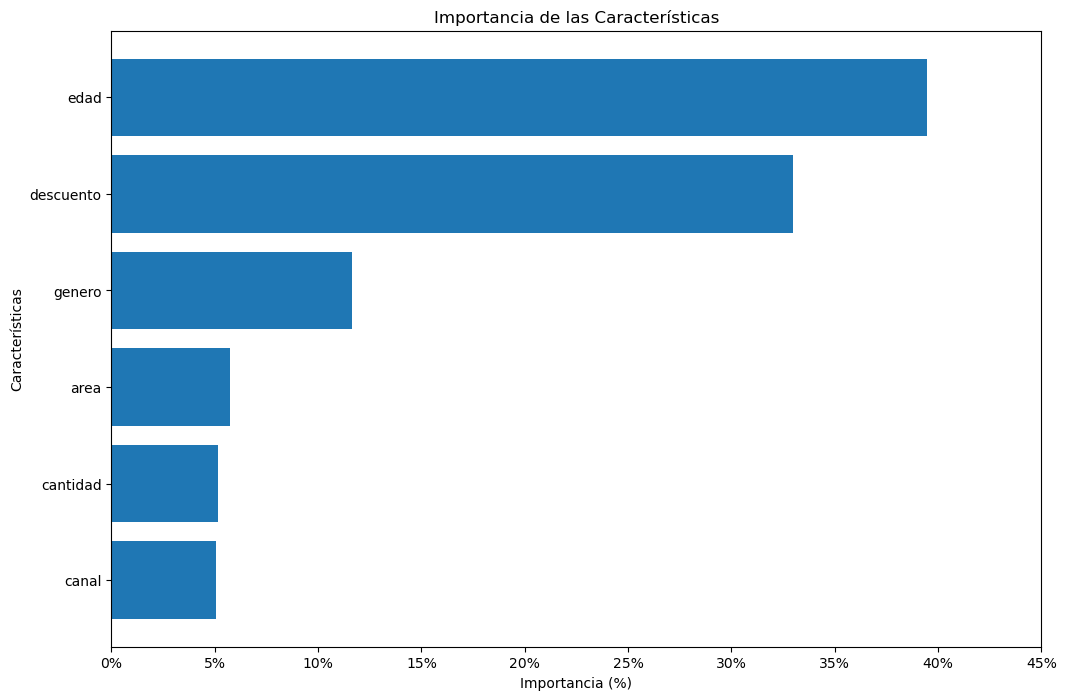

In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que df_resultado ya está definido y contiene los datos procesados
df_resultado = df_resultado  # Asegúrate de que df_resultado esté correctamente definido

# Seleccionar las características (features) y la variable objetivo (target)
columns_to_keep = ['cantidad_x', 'area_x', 'genero_x', 'canal_x', 'edad_x', 'descuento', 'edad_ano_talla_hoy_x']
features = df_resultado[columns_to_keep]
target = df_resultado['frecuencia']

# Filtrar valores de 'porcentaje_descuento_x' fuera del rango [0, 1]
features = features[(features['descuento'] >= 0) & (features['descuento'] <= 1)]

# Codificar variables categóricas como numéricas
features = pd.get_dummies(features)
target = pd.factorize(target)[0]

# Filtrar valores extremos solo en las columnas numéricas
num_cols = features.select_dtypes(include=[np.number]).columns
features[num_cols] = features[num_cols].apply(lambda x: np.clip(x, a_min=x.quantile(0.01), a_max=x.quantile(0.99)))

# Calcular la matriz de correlación y eliminar características altamente correlacionadas
correlation_matrix = features.corr()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.9)]
features = features.drop(columns=to_drop)

# Verificar y limpiar los datos (eliminar valores nulos y tipos inconsistentes)
features.dropna(inplace=True)

# Alinear el target con las características después de eliminar valores nulos
target = target[:len(features)]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Crear el modelo de árbol de decisión con una profundidad máxima
clf = DecisionTreeClassifier(random_state=42, max_depth=10)
clf.fit(X_train, y_train)

# Obtener la importancia de las características
importances = clf.feature_importances_
feature_names = features.columns

# Agrupar las características en categorías principales
feature_names_grouped = feature_names.str.split('_').str[0]

# Crear un DataFrame para la importancia de las características
feature_importance_df = pd.DataFrame({'Feature': feature_names_grouped, 'Importance': importances})
feature_importance_df = feature_importance_df.groupby('Feature').sum().sort_values(by='Importance', ascending=False)

# Filtrar las características más importantes (por ejemplo, las 10 principales)
top_features = feature_importance_df.head(10)

# Visualizar la importancia de las características más importantes
plt.figure(figsize=(12, 8))
plt.barh(top_features.index, top_features['Importance'] * 100)  # Convertir a porcentaje
plt.xlabel('Importancia (%)')  # Modificar etiqueta del eje X
max_importance = top_features['Importance'].max() * 100  # Calcular el valor máximo de importancia
plt.xlim(0, max_importance + 5)  # Establecer el límite del eje X ligeramente por encima del valor máximo
plt.xticks(ticks=np.arange(0, max_importance + 6, 5), labels=[f'{int(i)}%' for i in np.arange(0, max_importance + 6, 5)])  # Añadir % en el eje X sin decimales
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.gca().invert_yaxis()
plt.show()


correo        object
edad_x       float64
descuento    float64
dtype: object
(4281, 3)
                          correo  edad_x  descuento
0       1209silvaaraya@gmail.com    32.0   0.152205
1             154281102@meli.com    30.0   0.000000
2             176606188@meli.com    31.0   0.000000
3  1987felipealejandro@gmail.com    32.0   0.243919
4             216022041@meli.com    32.0   0.455183
correo       0
edad_x       0
descuento    0
dtype: int64
correo       0
edad_x       0
descuento    0
dtype: int64
[[-0.32597338 -0.20667166]
 [-0.49058304 -1.26538559]
 [-0.40827821 -1.26538559]
 ...
 [-2.05437475 -1.26538559]
 [ 0.00324592  0.12611131]
 [-2.63050854  0.31155981]]


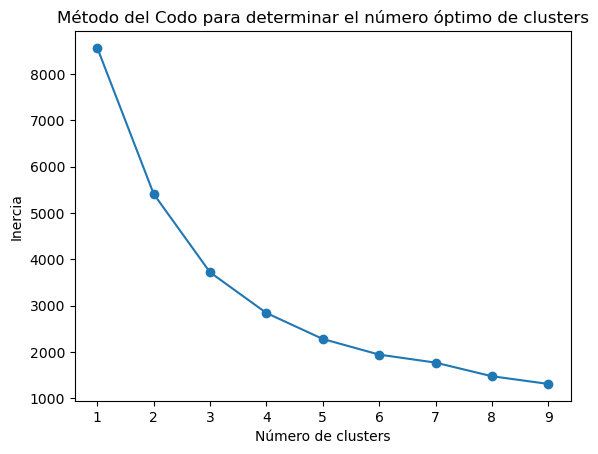

Número de filas: 4281, Correos únicos: 4281


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler

# Agrupar por correo y calcular el promedio de 'edad_x', 'edad_ano_talla_hoy_x' y 'porcentaje_descuento_x'
df_grouped = df_resultado.groupby('correo')[['edad_x', 'descuento']].mean().reset_index()

# Verificar los tipos de datos y la forma del DataFrame
print(df_grouped.dtypes)
print(df_grouped.shape)  # Comprobar la forma después del agrupamiento
print(df_grouped.head())  # Verificar los primeros datos

# Filtrar valores de 'porcentaje_descuento_x' fuera del rango [0, 1]
df_grouped = df_grouped[(df_grouped['descuento'] >= 0) & (df_grouped['descuento'] <= 1)]

# Verificar si hay valores NaN, infinitos o negativos infinitos
print(df_grouped.isna().sum())
print(df_grouped.isin([np.nan, np.inf, -np.inf]).sum())

# Eliminar filas con valores NaN o infinitos
df_grouped = df_grouped.dropna()
df_grouped = df_grouped.replace([np.inf, -np.inf], np.nan).dropna()

# Asegurarse de que las columnas sean numéricas
df_grouped['edad_x'] = pd.to_numeric(df_grouped['edad_x'])
df_grouped['descuento'] = pd.to_numeric(df_grouped['descuento'])

# Seleccionar solo las columnas 'edad_x', 'edad_ano_talla_hoy_x' y 'porcentaje_descuento_x' para el análisis de clustering
df_selected = df_grouped[['edad_x', 'descuento']]

# Normalizar los datos
scaler = StandardScaler()
df_selected_scaled = scaler.fit_transform(df_selected)

# Verificar el contenido de df_selected_scaled
print(df_selected_scaled)

# Lista para almacenar las inercia (codo)
inertias = []
K = range(1, 10)  # Ajustar el rango de K para más clusters

# Ejecutar KMeans para diferentes valores de k con manejo de errores
try:
    for k in K:
        kmeans = cluster.KMeans(n_clusters=k, random_state=1, init="k-means++", n_init="auto")
        kmeans.fit(df_selected_scaled)  # Usar las columnas seleccionadas y normalizadas
        inertias.append(kmeans.inertia_)
except ValueError as e:
    print(f"Error with k={k}: {e}")

# Graficar el codo
if inertias:
    plt.plot(K, inertias, marker='o')
    plt.title("Método del Codo para determinar el número óptimo de clusters")
    plt.xlabel("Número de clusters")
    plt.ylabel("Inercia")
    plt.show()

# Obtener el número de filas del dataframe y el conteo de correos únicos
num_filas = df_resultado.shape[0]
correos_unicos = df_resultado['correo'].nunique()
print(f"Número de filas: {num_filas}, Correos únicos: {correos_unicos}")


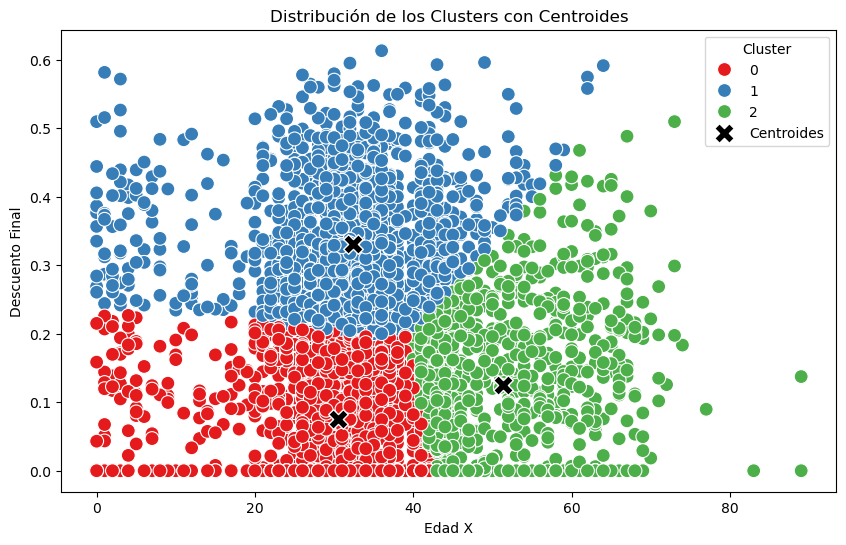

Cluster 1:
Rango de edad_x: 0.0 - 42.0
Rango de descuento_final: 0.0% - 22.7%

Cluster 2:
Rango de edad_x: 0.0 - 64.0
Rango de descuento_final: 19.7% - 61.3%

Cluster 3:
Rango de edad_x: 40.0 - 89.0
Rango de descuento_final: 0.0% - 51.0%

   Cluster  Edad X Min  Edad X Max Descuento Final Min Descuento Final Max
0        1         0.0        42.0                0.0%               22.7%
1        2         0.0        64.0               19.7%               61.3%
2        3        40.0        89.0                0.0%               51.0%


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Agrupar por correo y calcular el promedio de 'edad_x' y 'descuento_final'
df_grouped = df_resultado.groupby('correo')[['edad_x', 'descuento']].mean().reset_index()

# Seleccionar solo las columnas 'edad_x' y 'descuento_final' para el análisis de clustering
df_selected = df_grouped[['edad_x', 'descuento']]

# Asegurarse de que las columnas seleccionadas sean numéricas
df_selected = df_selected.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores NaN (si es necesario)
df_selected = df_selected.dropna()

# Escalar las variables 'edad_x' y 'descuento_final'
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected[['edad_x', 'descuento']])

# Ajustar el modelo KMeans con 3 clusters usando los datos escalados
kmeans = KMeans(n_clusters=3, random_state=1, init="k-means++", n_init="auto")
kmeans.fit(df_scaled)

# Agregar los labels (asignación de clusters) al DataFrame
df_selected['Cluster'] = kmeans.labels_

# Obtener los centroides de los clusters (en escala original)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Graficar la distribución de los clusters con centroides
plt.figure(figsize=(10, 6))

# Gráfico de dispersión con los clusters coloreados
sns.scatterplot(data=df_selected, x='edad_x', y='descuento', hue='Cluster', palette='Set1', s=100, marker='o', legend='full')

# Añadir los centroides al gráfico (desescalados)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, marker='X', label='Centroides', edgecolor='white')

# Personalizar el gráfico
plt.title("Distribución de los Clusters con Centroides")
plt.xlabel("Edad X")
plt.ylabel("Descuento Final")
plt.legend(title="Cluster")
plt.show()

# Reducir el tamaño del conjunto de datos (usa solo el 10% de los datos originales)
df_resultado_sample = df_resultado.sample(frac=0.1, random_state=1)

# Agregar la columna 'Cluster' a df_resultado usando las variables 'edad_x' y 'descuento_final'
df_resultado = df_resultado_sample.merge(df_selected[['edad_x', 'descuento', 'Cluster']], on=['edad_x', 'descuento'], how='left')

# Rango de edades para cada cluster
for cluster_num in range(kmeans.n_clusters):
    cluster_data = df_selected[df_selected['Cluster'] == cluster_num]
    edad_x_min = cluster_data['edad_x'].min()
    edad_x_max = cluster_data['edad_x'].max()
    descuento_final_min = cluster_data['descuento'].min()
    descuento_final_max = cluster_data['descuento'].max()
    print(f"Cluster {cluster_num + 1}:")
    print(f"Rango de edad_x: {edad_x_min} - {edad_x_max}")
    print(f"Rango de descuento_final: {descuento_final_min*100:.1f}% - {descuento_final_max*100:.1f}%")
    print("")

# Opción alternativa: Mostrar en formato de tabla
cluster_ranges = []
for cluster_num in range(kmeans.n_clusters):
    cluster_data = df_selected[df_selected['Cluster'] == cluster_num]
    edad_x_min = cluster_data['edad_x'].min()
    edad_x_max = cluster_data['edad_x'].max()
    descuento_final_min = cluster_data['descuento'].min()
    descuento_final_max = cluster_data['descuento'].max()
    rango_descuento_final_min = f"{descuento_final_min*100:.1f}%"
    rango_descuento_final_max = f"{descuento_final_max*100:.1f}%"
    cluster_ranges.append([cluster_num + 1, edad_x_min, edad_x_max, rango_descuento_final_min, rango_descuento_final_max])

df_cluster_ranges = pd.DataFrame(cluster_ranges, columns=['Cluster', 'Edad X Min', 'Edad X Max', 'Descuento Final Min', 'Descuento Final Max'])
print(df_cluster_ranges)


### **Comportamiento clientes diciembre 2022 y 2023**

In [10]:
import pandas as pd

# Crear una copia del DataFrame original para asegurar la integridad de los datos
df_diciembre = df_final_1.copy()

# Convertir la columna de fechas a tipo datetime, en caso de que no lo esté
df_diciembre['fecha'] = pd.to_datetime(df_diciembre['fecha'])

# Filtrar los datos para incluir sólo diciembre de 2022, 2023 y 2024
df_diciembre = df_diciembre[
    ((df_diciembre['fecha'].dt.year == 2022) | 
     (df_diciembre['fecha'].dt.year == 2023) ) & 
    (df_diciembre['fecha'].dt.month == 12)
]

# Obtener los correos únicos
correos_unicos = df_diciembre['correo'].nunique()

print(f'Número de correos únicos en diciembre de 2022, 2023: {correos_unicos}')


Número de correos únicos en diciembre de 2022, 2023: 145708


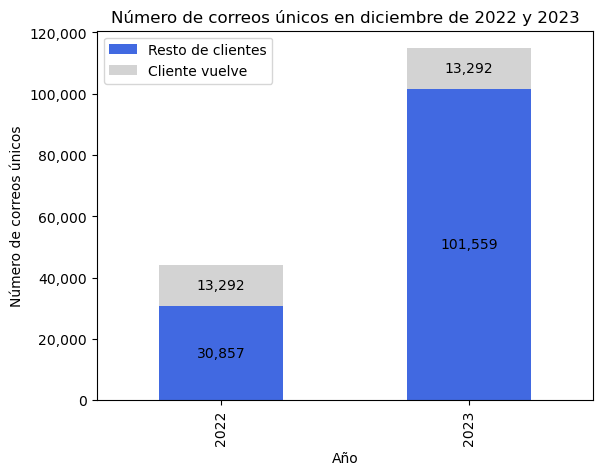

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Crear una copia del DataFrame original para asegurar la integridad de los datos
df_diciembre = df_final_1.copy()

# Convertir la columna de fechas a tipo datetime, en caso de que no lo esté
df_diciembre['fecha'] = pd.to_datetime(df_diciembre['fecha'])

# Filtrar los datos para incluir sólo diciembre de 2022 y 2023
df_diciembre = df_diciembre[
    ((df_diciembre['fecha'].dt.year == 2022) | 
     (df_diciembre['fecha'].dt.year == 2023)) & 
    (df_diciembre['fecha'].dt.month == 12)
]

# Crear un DataFrame vacío para almacenar los datos de correos únicos
unique_emails = pd.DataFrame(columns=['Year', 'Email'])

# Añadir correos únicos por año usando pd.concat en lugar de append
for year in [2022, 2023]:
    emails_year = df_diciembre[df_diciembre['fecha'].dt.year == year]['correo'].unique()
    unique_emails = pd.concat([unique_emails, pd.DataFrame({'Year': year, 'Email': emails_year})])

# Identificar correos que se repiten en varios años
repeated_emails = unique_emails.duplicated(subset=['Email'], keep=False)

# Crear una columna para identificar si el correo es repetido
unique_emails['Repeated'] = repeated_emails

# Contar correos únicos y repetidos por año
unique_counts = unique_emails.groupby(['Year', 'Repeated']).size().unstack(fill_value=0)

# Crear el gráfico de barras
fig, ax = plt.subplots()

# Crear barras para correos únicos y repetidos con colores suaves
bars = unique_counts.plot(kind='bar', stacked=True, ax=ax, color=['#4169E1', '#D3D3D3'])  # azul real y gris claro

# Añadir etiquetas y título
ax.set_xlabel('Año')
ax.set_ylabel('Número de correos únicos')
ax.set_title('Número de correos únicos en diciembre de 2022 y 2023')
ax.legend(['Resto de clientes', 'Cliente vuelve'])

# Añadir etiquetas de datos con separador de miles
total_counts = unique_counts.sum(axis=1)
for i, container in enumerate(bars.containers):
    year = unique_counts.index[i // 2]  # Índice del año correspondiente
    labels = [f'{v:,.0f}' for v in container.datavalues]
    bars.bar_label(container, labels=labels, label_type='center')

# Formatear el eje y con separador de miles
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

# Mostrar el gráfico
plt.show()


In [12]:
# Filtrar los correos únicos de los clusters 2, 4 y 5
clusters_to_include = [0, 1, 3]
df_cluster_cruce_dec = df_resultado[df_resultado['Cluster'].isin(clusters_to_include)]['correo'].unique()

# Convertir la lista de correos únicos en un DataFrame
df_cluster_cruce_dec = pd.DataFrame(df_cluster_cruce_dec, columns=['correo'])

# Mostrar el DataFrame resultante
print("DataFrame de correos únicos de los clusters 2, 4 y 5:")
print(df_cluster_cruce_dec)

# Mostrar el conteo de correos únicos
unique_email_count = df_cluster_cruce_dec['correo'].nunique()
print(f"\nConteo de correos únicos en los clusters 2, 4 y 5: {unique_email_count}")


DataFrame de correos únicos de los clusters 2, 4 y 5:
                                 correo
0                 elvi.guerra@gmail.com
1         gonzalez.subiabre.a@gmail.com
2             macarena.vega.s@gmail.com
3            cristianpedreros@gmail.com
4      constanzaguerrerotapia@gmail.com
...                                 ...
68980               lmoyam.lm@gmail.com
68981             laeti2502@hotmail.com
68982         lilianarivera26@gmail.com
68983              narce.isla@gmail.com
68984              veronacruz@gmail.com

[68985 rows x 1 columns]

Conteo de correos únicos en los clusters 2, 4 y 5: 68985


In [13]:
import pandas as pd

# Suponiendo que ya tienes los DataFrames df_diciembre y df_cluster_cruce_dec
# Reemplaza esta línea con la carga o definición de tus DataFrames
# df_diciembre = ...
# df_cluster_cruce_dec = ...

# Filtramos los correos de diciembre de 2023
correos_diciembre = set(df_diciembre.loc[
    (df_diciembre['fecha'].dt.year == 2023) & 
    (df_diciembre['fecha'].dt.month == 12), 'correo'].unique())

correos_cluster = set(df_cluster_cruce_dec['correo'].unique())

# Correos que no se cruzan
correos_sin_cruzar = correos_diciembre - correos_cluster

# Correos que sí se cruzan
correos_cruzados = correos_diciembre & correos_cluster

# Creamos los DataFrames correspondientes
df_dec_sin_cruzar_con_cluster = df_diciembre[df_diciembre['correo'].isin(correos_sin_cruzar)]
df_dec_cruzados_con_cluster = df_diciembre[df_diciembre['correo'].isin(correos_cruzados)]

# Contamos los correos únicos que no se cruzaron
conteo_sin_cruzar = len(correos_sin_cruzar)
print(f"Cantidad de correos únicos en df_diciembre que no se cruzaron: {conteo_sin_cruzar}")

# Contamos los correos únicos que sí se cruzaron
conteo_cruzados = len(correos_cruzados)
print(f"Cantidad de correos únicos en df_diciembre que sí se cruzaron: {conteo_cruzados}")

# Verificamos la suma total de correos únicos
total_unicos = conteo_sin_cruzar + conteo_cruzados
print(f"Suma total de correos únicos: {total_unicos}")


Cantidad de correos únicos en df_diciembre que no se cruzaron: 91176
Cantidad de correos únicos en df_diciembre que sí se cruzaron: 23675
Suma total de correos únicos: 114851


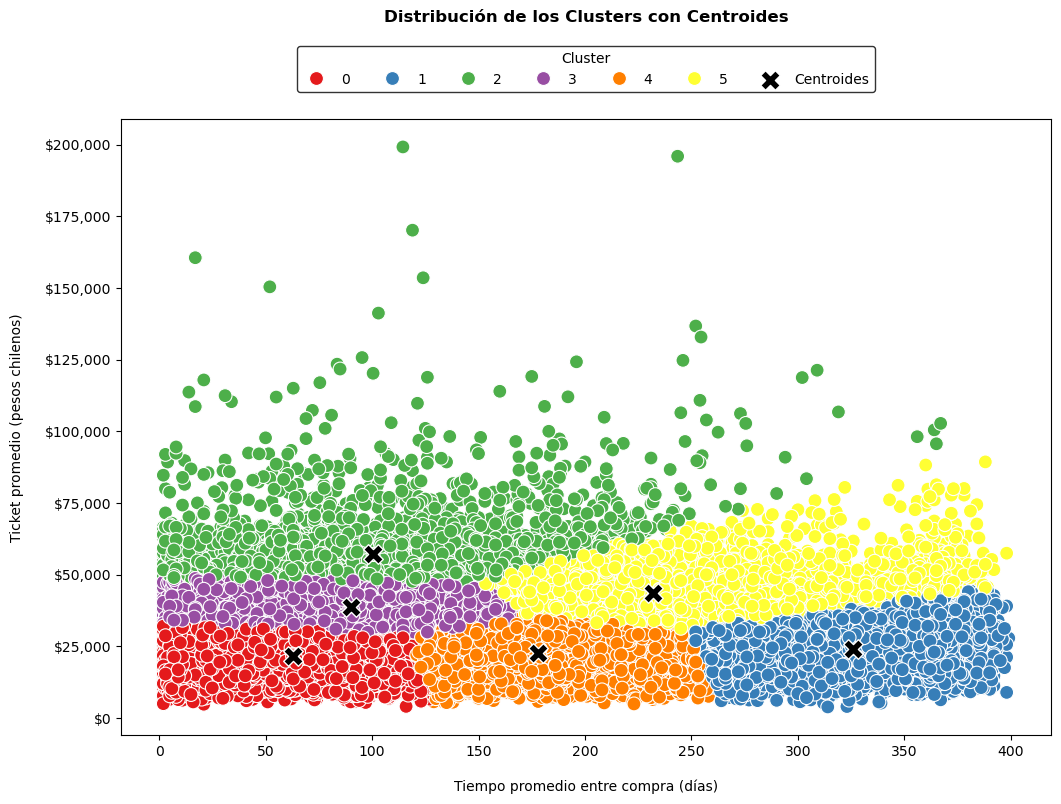

Cluster,Correo_Únicos,Min TPC,Max TPC,Min TICKET PROMEDIO,Max TICKET PROMEDIO,cantidad_x,area_x,genero_x,canal_x,edad_x,edad_ano_talla_hoy_x,frecuencia,descuento
0,2176,2,127,"$4,040","$32,316",1.004,"CALZADO: 47%, ROPA: 43%, MIXTO: 10%","GIRL: 50%, BOY: 42%, MIXTO: 6%, Sin Genero: 3%","OFFLINE: 93%, ONLINE: 6%, MIXTO: 1%",34.2,5.3,5,35.95%
1,975,251,398,"$5,191","$44,354",1.011,"CALZADO: 46%, ROPA: 45%, MIXTO: 9%","GIRL: 52%, BOY: 42%, MIXTO: 4%, Sin Genero: 2%","OFFLINE: 97%, ONLINE: 3%, MIXTO: 0%",36.0,5.5,2,33.84%
2,1115,2,365,"$47,306","$160,567",1.020,"CALZADO: 48%, ROPA: 35%, MIXTO: 17%","GIRL: 57%, BOY: 32%, MIXTO: 9%, Sin Genero: 1%","OFFLINE: 95%, ONLINE: 4%, MIXTO: 1%",36.0,5.9,3,24.13%
3,2161,2,168,"$29,040","$48,980",1.010,"CALZADO: 46%, ROPA: 39%, MIXTO: 15%","GIRL: 55%, BOY: 37%, MIXTO: 6%, Sin Genero: 2%","OFFLINE: 95%, ONLINE: 4%, MIXTO: 1%",35.4,5.8,4,29.13%
4,1916,118,254,"$6,640","$34,811",1.005,"ROPA: 47%, CALZADO: 45%, MIXTO: 8%","GIRL: 53%, BOY: 41%, MIXTO: 4%, Sin Genero: 2%","OFFLINE: 95%, ONLINE: 4%, MIXTO: 1%",35.9,5.4,4,36.29%
5,1083,152,391,"$31,116","$88,246",1.014,"CALZADO: 51%, ROPA: 36%, MIXTO: 14%","GIRL: 55%, BOY: 38%, MIXTO: 5%, Sin Genero: 1%","OFFLINE: 96%, ONLINE: 3%, MIXTO: 0%",35.7,5.8,2,30.07%


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Agrupar por correo y calcular el promedio de 'TPC' y 'TICKET PROMEDIO'
df_grouped_dec = df_dec_sin_cruzar_con_cluster.groupby('correo')[['TPC', 'TICKET PROMEDIO']].mean().reset_index()

# Seleccionar solo las columnas 'TPC' y 'TICKET PROMEDIO' para el análisis de clustering
df_selected_dec = df_grouped_dec[['TPC', 'TICKET PROMEDIO']]

# Asegurarse de que las columnas seleccionadas sean numéricas
df_selected_dec = df_selected_dec.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores NaN (si es necesario)
df_selected_dec = df_selected_dec.dropna()

# Escalar las variables 'TPC' y 'TICKET PROMEDIO'
scaler = StandardScaler()
df_scaled_dec = scaler.fit_transform(df_selected_dec[['TPC', 'TICKET PROMEDIO']])

# Ajustar el modelo KMeans con 6 clusters usando los datos escalados
kmeans = KMeans(n_clusters=6, random_state=1, init="k-means++", n_init="auto")
kmeans.fit(df_scaled_dec)

# Agregar los labels (asignación de clusters) al DataFrame
df_selected_dec['Cluster'] = kmeans.labels_

# Obtener los centroides de los clusters (en escala original)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Graficar la distribución de los clusters con centroides
plt.figure(figsize=(12, 8))  # Ampliar la figura para mayor claridad

# Gráfico de dispersión con los clusters coloreados
sns.scatterplot(data=df_selected_dec, x='TPC', y='TICKET PROMEDIO', hue='Cluster', palette='Set1', s=100, marker='o', legend='full')

# Añadir los centroides al gráfico (desescalados)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, marker='X', label='Centroides', edgecolor='white')

# Personalizar el gráfico
plt.title("Distribución de los Clusters con Centroides", pad=70, fontweight='bold')  # Añadir negrita al título
plt.xlabel("Tiempo promedio entre compra (días)", labelpad=15)
plt.ylabel("Ticket promedio (pesos chilenos)", labelpad=15)

# Ajustar la leyenda con recuadro negro
legend = plt.legend(title="Cluster", loc="upper center", bbox_to_anchor=(0.5, 1.13), ncol=7, frameon=True)
legend.get_frame().set_edgecolor('black')

# Formatear los valores del eje y
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))

# Formatear los valores del eje x
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x).replace(',', '.')))

plt.show()

# Agregar la columna 'Cluster' a df_selected con las variables 'TPC' y 'TICKET PROMEDIO'
df_selected_dec = df_selected_dec[['TPC', 'TICKET PROMEDIO', 'Cluster']]

# Reducir el tamaño del conjunto de datos (usa solo el 10% de los datos originales)
df_dec_sin_cruzar_con_cluster_sample = df_dec_sin_cruzar_con_cluster.sample(frac=0.1, random_state=1)

# Agregar la columna 'Cluster' a df_final_2 usando las variables 'TPC' y 'TICKET PROMEDIO'
df_dec_sin_cruzar_con_cluster_sample = df_dec_sin_cruzar_con_cluster_sample.merge(df_selected_dec, on=['TPC', 'TICKET PROMEDIO'], how='left')

# Unir df_final_2_sample con df_unificado usando 'correo' para asegurarnos de tener todas las columnas necesarias
df_resultado_dec_final = df_dec_sin_cruzar_con_cluster_sample.merge(df_unificado, on='correo', how='left')

# Función para categorizar áreas, géneros y canales, incluyendo la condición especial para ACCESORIOS
def categorize_column(column_values):
    unique_values = column_values.unique()
    if len(unique_values) == 1:
        return 'ROPA' if unique_values[0] == 'ACCESORIOS' else unique_values[0]
    else:
        return 'MIXTO'

# Aplicar la función de categorización
df_resultado_dec_final['area_x'] = df_resultado_dec_final.groupby('correo')['area_x'].transform(categorize_column)
df_resultado_dec_final['genero_x'] = df_resultado_dec_final.groupby('correo')['genero_x'].transform(categorize_column)
df_resultado_dec_final['canal_x'] = df_resultado_dec_final.groupby('correo')['canal_x'].transform(categorize_column)

# Calcular el conteo de correos únicos por cluster
unique_emails_per_cluster = df_resultado_dec_final.groupby('Cluster')['correo'].nunique().reset_index()
unique_emails_per_cluster.columns = ['Cluster', 'Correo_Únicos']

# Calcular el rango de TPC y TICKET PROMEDIO por cluster
ranges = df_resultado_dec_final.groupby('Cluster').agg({
    'TPC': ['min', 'max'],
    'TICKET PROMEDIO': ['min', 'max']
}).reset_index()
ranges.columns = ['Cluster', 'Min TPC', 'Max TPC', 'Min TICKET PROMEDIO', 'Max TICKET PROMEDIO']

# Unir los conteos de correos y los rangos
cluster_info = pd.merge(unique_emails_per_cluster, ranges, on='Cluster')

# Función para formatear los porcentajes sin decimales ni puntos
def format_percentage_without_decimals(column_values):
    return ', '.join([f"{value}: {int(round((count / len(column_values)) * 100))}%" for value, count in column_values.value_counts().items()])

# Calcular las medias y porcentajes por categoría para cada cluster
additional_stats = df_resultado_dec_final.groupby('Cluster').agg({
    'cantidad_x': 'mean',
    'area_x': lambda x: format_percentage_without_decimals(x),
    'genero_x': lambda x: format_percentage_without_decimals(x),
    'canal_x': lambda x: format_percentage_without_decimals(x),
    'edad_x': 'mean',
    'edad_ano_talla_hoy_x': 'mean',
    'frecuencia': 'first',
    'descuento': 'mean'  # Agregar descuento_final a las estadísticas adicionales
}).reset_index()

# Unir la información adicional al DataFrame de clusters
cluster_info = pd.merge(cluster_info, additional_stats, on='Cluster')

# Formatear las columnas según lo solicitado
cluster_info['Cluster'] = cluster_info['Cluster'].map(lambda x: f"{x:.0f}")
cluster_info['Min TPC'] = cluster_info['Min TPC'].map(lambda x: f"{x:,.0f}")
cluster_info['Max TPC'] = cluster_info['Max TPC'].map(lambda x: f"{x:,.0f}")
cluster_info['Min TICKET PROMEDIO'] = cluster_info['Min TICKET PROMEDIO'].map(lambda x: f"${x:,.0f}")
cluster_info['Max TICKET PROMEDIO'] = cluster_info['Max TICKET PROMEDIO'].map(lambda x: f"${x:,.0f}")
cluster_info['cantidad_x'] = cluster_info['cantidad_x'].map(lambda x: f"{x:,.3f}")
cluster_info['edad_x'] = cluster_info['edad_x'].map(lambda x: f"{x:,.1f}")
cluster_info['edad_ano_talla_hoy_x'] = cluster_info['edad_ano_talla_hoy_x'].map(lambda x: f"{x:,.1f}")
cluster_info['descuento'] = cluster_info['descuento'].map(lambda x: f"{x * 100:.2f}%")  # Formatear descuento_final como porcentaje con dos decimales


# Añadir colores de clusters
colors = sns.color_palette("Set1", n_colors=6).as_hex()
cluster_info['Color'] = cluster_info['Cluster'].map(lambda x: colors[int(x)])

# Función para crear iconos de colores en HTML
def create_color_icon(color):
    return f'<svg height="15" width="15"><circle cx="7.5" cy="7.5" r="7.5" fill="{color}" /></svg>'

# Añadir icono de color al nombre del cluster
cluster_info['Cluster'] = cluster_info.apply(lambda row: f'{create_color_icon(row["Color"])} {row["Cluster"]}', axis=1)

# Eliminar la columna de color antes de mostrar
cluster_info = cluster_info.drop(columns=['Color'], errors='ignore')

# Mostrar la información de cada cluster en formato de tabla
from IPython.display import display, HTML

# Convertir el DataFrame a HTML para mejor visualización
display(HTML(cluster_info.to_html(index=False, escape=False)))
